# Telecom Churn Case Study


### Problem Statement

1. In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

2. For many incumbent operators, retaining high profitable customers is the number one business goal.

3. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.


### Definitions of Churn

There are various ways to define churn, such as:

__Revenue-based churn:__ Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.

__Usage-based churn:__ Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

### Understanding Customer Behaviour During Churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

## Business objective

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

__The steps we will follow in this are as follows:__

1. Importing data.
2. Churn customers.
3. Missing value treatment.
4. Exploratory analysis.
5. Derived features.
6. Feature Selection.
7. Model Building.
8. Choice of Evaluation Metric
9. Important features or indicators.
10. Recommendations to Business


In [1]:
# Let us first import libraries
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline

from scipy.stats import norm
from scipy import stats

import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

### Custom Methods
Let's define all custom methods here for code conciseness.

In [2]:
# Let's define a method for checking missing value count per column.
def null_Count_in_dataset(data_frame, threshold):
    null_value = data_frame.isnull().sum()
    return null_value.loc[null_value > threshold]

In [3]:
# Let's define a method for checking missing value percentage per column.
def null_Percentage_in_dataset(data_frame, threshold):
    null_value = 100 * round(data_frame.isnull().sum()/len(data_frame.index),2).sort_values(ascending=False)
    return null_value.loc[null_value > threshold]

In [4]:
# Based on condition it will return 0 or 1
def flag(data_frame,action_col,avg_col):
    return np.where((data_frame[action_col] > data_frame[avg_col]), 0, 1)

In [5]:
# It will return the difference between the two columns
def diff(data_frame,col_1,col_2):
    return data_frame[col_1] - data_frame[col_2]

### Custom methods for Plotting and Visualization

In [6]:
# Defining method for pair plot
def pair_plot(data_frame,cols):
    sns.pairplot(data=data_frame[cols],hue='churn_flag')

In [7]:
# Defining the method for sub_plot and distplot
def sub_plot(data_frame,col):
    fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize = (12, 4))
    ax = sns.distplot(data_frame[data_frame['churn_flag'] == 1][col], bins = 30, ax = axes[0], kde = False)
    ax.set_title('Churn')
    ax = sns.distplot(data_frame[data_frame['churn_flag'] == 0][col], bins = 30, ax = axes[1], kde = False)
    ax.set_title('Non-Churn')

    fig, axes = plt.subplots(nrows = 1, ncols = 1,figsize = (12, 4))
    sns.boxplot(x = 'churn_flag', y = col, data = data_frame)
    sns.stripplot(x = 'churn_flag', y = col, data = data_frame, jitter = True, edgecolor = "gray")

### Lift Metric

__What is Lift measure?__

Lift can be understood as a ratio of two percentages: the percentage of correct positive classifications made by the model to the percentage of actual positive classifications in the test data.

In [8]:
# Defining method for plotting of lift metrics
def plotLiftChart(actual, predicted,title_str):
    df_dict = {'actual': list (actual), 'pred': list(predicted)}
    df = pd.DataFrame(df_dict)
    pred_ranks = pd.qcut(df['pred'].rank(method='first'), 100, labels=False)
    actual_ranks = pd.qcut(df['actual'].rank(method='first'), 100, labels=False)
    pred_percentiles = df.groupby(pred_ranks).mean()
    actual_percentiles = df.groupby(actual_ranks).mean()
    plt.title(title_str)
    plt.plot(np.arange(.01, 1.01, .01), np.array(pred_percentiles['pred']),
             color='darkorange', lw=2, label='Prediction')
    plt.plot(np.arange(.01, 1.01, .01), np.array(pred_percentiles['actual']),
             color='navy', lw=2, linestyle='--', label='Actual')
    plt.ylabel('Target Percentile')
    plt.xlabel('Population Percentile')
    plt.xlim([0.0, 1.0])
    plt.ylim([-0.05, 1.05])
    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 4

    plt.legend(loc="best")
    plt.show()

# Importing  data

In [9]:
# Load data to pandas dataframe
telecom_data = pd.read_csv('/Users/balwant/telecom_churn_data.csv')

In [10]:
# Firstly, let's have a look at the dimension of data
telecom_data.shape

(99999, 226)

In [11]:
# Let's have a look at the first few rows of the Data
telecom_data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

In [12]:
# Let's have a look at all the column names
list(telecom_data.columns)

['mobile_number',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'onnet_mou_9',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'offnet_mou_9',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2t_mou_9',
 's

### Churn definition
Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time. In our analysis we are concentrating on high value customers, as approximately 80% of revenue comes from the top 20% customers. Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

Our dataset is divided into 3 phases:
Good phase wherein the customer is happy with the service.

Action phase wherein the customer wasn't happy with service or got a better offer from competitor etc. In this phase, the customer usually shows different behaviour than the good phase. Also, it is crucial to identify high-churn-risk customers in this phase, so that some corrective actions can be taken at this point to prevet churn.

Churn phase wherein the customer would have churned

High-value customers are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
After identifying high value customers, we will tag churn customers based on those who have not made any calls (either incoming or outgoing) and have not used mobile internet even once in the churn phase.

Let's first identify high-value customers

In [13]:
telecom_data['total_data_rech_6'] = telecom_data['total_rech_data_6'] * telecom_data['av_rech_amt_data_6']
telecom_data['total_data_rech_7'] = telecom_data['total_rech_data_7'] * telecom_data['av_rech_amt_data_7']

telecom_data['amt_data_6'] = telecom_data[['total_rech_amt_6','total_data_rech_6']].sum(axis=1)
telecom_data['amt_data_7'] = telecom_data[['total_rech_amt_7','total_data_rech_7']].sum(axis=1)

telecom_data['AVG_amt_data_6_7'] = telecom_data[['amt_data_6','amt_data_7']].mean(axis=1)

In [14]:
#Let's have a look on few rows after adding some columns
telecom_data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

In [15]:
# Lets have a look on percentile of below columns
telecom_data[['total_rech_amt_6','total_rech_amt_7','AVG_amt_data_6_7']].quantile(np.linspace(.1, 1, 9, 0))

total_rech_amt_6  total_rech_amt_7  AVG_amt_data_6_7
0.1               0.0               0.0              60.0
0.2              80.0              65.0             108.5
0.3             120.0             110.0             155.0
0.4             170.0             160.0             209.5
0.5             230.0             220.0             275.0
0.6             290.0             283.0             360.0
0.7             378.0             370.0             478.0
0.8             504.0             500.0             656.5
0.9             732.0             731.0            1028.0


As per the definition of high value customers are those whose recharge amount should be more than or equal to 70th percentile.

But if we use greater than or equal to, we end up getting a little above 30K records as against to 29.9K records.
So, if we conisder only greater than, then we get 29.9K records.
Therefore we have considered greater than to filter high value customers

In [16]:
# Let's have a look on high value customers i.e. percentile greater than 70, and removing the rest of customers for analysis
data = telecom_data[(telecom_data['AVG_amt_data_6_7']> telecom_data['AVG_amt_data_6_7'].quantile(0.7))]
data.shape

(29953, 231)

# Churn customers

In [17]:
# Checking for churned customers based on following conditions
data['churn_flag'] = np.where(((data['total_ic_mou_9'] == 0.00) 
                            | (data['total_og_mou_9'] == 0.00))& ((data['vol_2g_mb_9'] == 0.00) 
                            | (data['vol_3g_mb_9'] == 0.00)), 1, 0)


In [18]:
# Let have look on dataframe after adding 'churn_flag' column in data
data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      7000842753        109             0.0             0.0             0.0   
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
21     7002124215        109             0.0             0.0             0.0   
23     7000887461        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0             6/30/2014            7/31/2014            8/31/2014   
7             6/30/2014            7/31/2014            8/31/2014   
8             6/30/2014            7/31/2014            8/31/2014   
21            6/30/2014            7/31/2014            8/31/2014   
23            6/30/2014            7/31/2014            8/31/2014   

   last_date_of_month_9    arpu_6    arpu_7    arpu_8   arpu_9  onnet_mou_6  \
0             9/30/2014   197.385   214.816   213.803   21.100          NaN   
7             9/30/2014  1069.180  1349.850  3171.480  500.000        57.84   
8             9/30/2014   378.721   492.223   137.362  166.787       413.69   
21            9/30/2014   514.453   597.753   637.760  578.596       102.41   
23            9/30/2014    74.350   193.897   366.966  811.480        48.96   

    onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0           NaN         0.00          NaN           NaN           NaN   
7         54.68        52.29          NaN        453.43        567.16   
8        351.03        35.08        33.46         94.66         80.63   
21       132.11        85.14       161.63        757.93        896.68   
23        50.66        33.58        15.74         85.41         89.36   

    offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0           0.00           NaN            NaN            NaN           0.00   
7         325.91           NaN          16.23          33.49          31.64   
8         136.48        108.71           0.00           0.00           0.00   
21        983.39        869.89           0.00           0.00           0.00   
23        205.89        111.88           0.00           0.00           0.00   

    roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0             NaN            NaN            NaN           0.00            NaN   
7             NaN          23.74          12.59          38.06            NaN   
8             0.0           0.00           0.00           0.00            0.0   
21            0.0           0.00           0.00           0.00            0.0   
23            0.0           0.00           0.00           0.00            0.0   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0                NaN               NaN              0.00               NaN   
7              51.39             31.38             40.28               NaN   
8             297.13            217.59             12.49             26.13   
21              4.48              6.16             23.34             29.98   
23             48.96             50.66             33.58             15.74   

    loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0                NaN               NaN              0.00               NaN   
7             308.63            447.38            162.28               NaN   
8              80.96             70.58             50.54             34.58   
21             91.81             87.93            104.81            107.54   
23             82.94             83.01            148.56             83.73   

    loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0                NaN               NaN              0.00               NaN   
7              62.13             55.14             53.23               NaN   
8               0.00              0.00              0.00    

In [19]:
# Let's have a look total numbers of churn and non churn 
print(data['churn_flag'].value_counts())
# Let's have a look total percentage of churn and non churn
print(data['churn_flag'].value_counts()/data.shape[0])

0    26698
1     3255
Name: churn_flag, dtype: int64
0    0.89133
1    0.10867
Name: churn_flag, dtype: float64


In [20]:
# Let's drop all features related to churn phase i.e. 9th month

In [21]:
data = data.drop(data.filter(regex='_9|sep', axis = 1).columns, axis=1)

In [22]:
# Let have look on data after drop 9 month from data set
data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      7000842753        109             0.0             0.0             0.0   
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
21     7002124215        109             0.0             0.0             0.0   
23     7000887461        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8    arpu_6  \
0             6/30/2014            7/31/2014            8/31/2014   197.385   
7             6/30/2014            7/31/2014            8/31/2014  1069.180   
8             6/30/2014            7/31/2014            8/31/2014   378.721   
21            6/30/2014            7/31/2014            8/31/2014   514.453   
23            6/30/2014            7/31/2014            8/31/2014    74.350   

      arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0    214.816   213.803          NaN          NaN         0.00           NaN   
7   1349.850  3171.480        57.84        54.68        52.29        453.43   
8    492.223   137.362       413.69       351.03        35.08         94.66   
21   597.753   637.760       102.41       132.11        85.14        757.93   
23   193.897   366.966        48.96        50.66        33.58         85.41   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0            NaN          0.00            NaN            NaN           0.00   
7         567.16        325.91          16.23          33.49          31.64   
8          80.63        136.48           0.00           0.00           0.00   
21        896.68        983.39           0.00           0.00           0.00   
23         89.36        205.89           0.00           0.00           0.00   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0             NaN            NaN           0.00               NaN   
7           23.74          12.59          38.06             51.39   
8            0.00           0.00           0.00            297.13   
21           0.00           0.00           0.00              4.48   
23           0.00           0.00           0.00             48.96   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0                NaN              0.00               NaN               NaN   
7              31.38             40.28            308.63            447.38   
8             217.59             12.49             80.96             70.58   
21              6.16             23.34             91.81             87.93   
23             50.66             33.58             82.94             83.01   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0               0.00               NaN               NaN              0.00   
7             162.28             62.13             55.14             53.23   
8              50.54              0.00              0.00              0.00   
21            104.81              0.75              0.00              1.58   
23            148.56              0.00              0.00              0.00   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0                NaN               NaN              0.00           NaN   
7                0.0               0.0              0.00        422.16   
8                0.0               0.0              7.15        378.09   
21               0.0               0.0              0.00         97.04   
23               0.0               0.0             17.71        131.91   

    loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0            NaN          0.00               NaN               NaN   
7         533.91        255.79              4.30             23.29   
8         288.18         63.04            116.56            133.43   
21         94.09    

In [23]:
# Let's have look on dataset shape
data.shape

(29953, 177)

Original data set having 231 columns but after droping 9 month data, Now data set having only 177 colunms.

In [24]:
#Let's check number of null value per column.
null_Count_in_dataset(data, 0)

loc_og_t2o_mou                223
std_og_t2o_mou                223
loc_ic_t2o_mou                223
last_date_of_month_7           27
last_date_of_month_8          165
onnet_mou_6                   542
onnet_mou_7                   536
onnet_mou_8                  1172
offnet_mou_6                  542
offnet_mou_7                  536
offnet_mou_8                 1172
roam_ic_mou_6                 542
roam_ic_mou_7                 536
roam_ic_mou_8                1172
roam_og_mou_6                 542
roam_og_mou_7                 536
roam_og_mou_8                1172
loc_og_t2t_mou_6              542
loc_og_t2t_mou_7              536
loc_og_t2t_mou_8             1172
loc_og_t2m_mou_6              542
loc_og_t2m_mou_7              536
loc_og_t2m_mou_8             1172
loc_og_t2f_mou_6              542
loc_og_t2f_mou_7              536
loc_og_t2f_mou_8             1172
loc_og_t2c_mou_6              542
loc_og_t2c_mou_7              536
loc_og_t2c_mou_8             1172
loc_og_mou_6  

In [25]:
#Let's check percentage of null value per column.
null_Percentage_in_dataset(data, 0)

arpu_2g_8                   47.0
fb_user_8                   47.0
total_rech_data_8           47.0
max_rech_data_8             47.0
count_rech_2g_8             47.0
count_rech_3g_8             47.0
av_rech_amt_data_8          47.0
arpu_3g_8                   47.0
night_pck_user_8            47.0
date_of_last_rech_data_8    47.0
arpu_3g_6                   44.0
night_pck_user_6            44.0
fb_user_6                   44.0
total_rech_data_6           44.0
date_of_last_rech_data_6    44.0
max_rech_data_6             44.0
count_rech_2g_6             44.0
arpu_2g_6                   44.0
count_rech_3g_6             44.0
total_data_rech_6           44.0
av_rech_amt_data_6          44.0
fb_user_7                   43.0
arpu_3g_7                   43.0
av_rech_amt_data_7          43.0
arpu_2g_7                   43.0
date_of_last_rech_data_7    43.0
count_rech_3g_7             43.0
night_pck_user_7            43.0
total_data_rech_7           43.0
count_rech_2g_7             43.0
max_rech_d

We can observe good amount of missing values in the dataset.
Let's treat them.
Before that let's identify features with single or unique value, because they won't be significant. Drop them

In [26]:
data.nunique()

mobile_number               29953
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
arpu_6                      29029
arpu_7                      29040
arpu_8                      28035
onnet_mou_6                 16872
onnet_mou_7                 16973
onnet_mou_8                 15854
offnet_mou_6                21198
offnet_mou_7                21233
offnet_mou_8                20140
roam_ic_mou_6                4045
roam_ic_mou_7                3381
roam_ic_mou_8                3431
roam_og_mou_6                4742
roam_og_mou_7                3988
roam_og_mou_8                3996
loc_og_t2t_mou_6            10416
loc_og_t2t_mou_7            10388
loc_og_t2t_mou_8            10056
loc_og_t2m_mou_6            15607
loc_og_t2m_mou_7            15659
loc_og_t2m_mou_8            15118
loc_og_t2f_mou

In [27]:
# let's identify features with single or unique value.
unique_stats = pd.DataFrame(data.nunique()).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
print(unique_stats[unique_stats['nunique'] == 1])

                 feature  nunique
1              circle_id        1
2         loc_og_t2o_mou        1
3         std_og_t2o_mou        1
4         loc_ic_t2o_mou        1
5   last_date_of_month_6        1
6   last_date_of_month_7        1
7   last_date_of_month_8        1
47      std_og_t2c_mou_6        1
48      std_og_t2c_mou_7        1
49      std_og_t2c_mou_8        1
86      std_ic_t2o_mou_6        1
87      std_ic_t2o_mou_7        1
88      std_ic_t2o_mou_8        1


In [28]:
# Features with single or unique value won't be significant. Let's drop them
data = data.drop(columns = list(unique_stats[unique_stats['nunique'] == 1]['feature']))

# Missing value treatment

Let's start with one of the highest missing feature arpu_3g_8

In [29]:
round(data['arpu_3g_8'].isna().sum() / len(data) * 100,2)

46.8

46.8% of the data is missing.
How can we impute them? using mean or median etc. 
Let's check them

In [30]:
data['arpu_3g_8'].describe()

count    15935.000000
mean       118.106064
std        218.976760
min        -24.490000
25%          0.000000
50%         10.020000
75%        179.630000
max       3716.900000
Name: arpu_3g_8, dtype: float64

We can observe that the range is huge.
We can't go with either mean or median as they can skew/distort the whole scenario.
Let's check data related variables of 8th month to decide on filling up the missing values


In [31]:

data[data['arpu_3g_8'].isna()][['date_of_last_rech_data_8','total_rech_data_8','max_rech_data_8','count_rech_2g_8', 
                            'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_2g_8',
                            'night_pck_user_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8',
                            'fb_user_8'
                           ]].nunique()

date_of_last_rech_data_8    0
total_rech_data_8           0
max_rech_data_8             0
count_rech_2g_8             0
count_rech_3g_8             0
av_rech_amt_data_8          0
vol_2g_mb_8                 1
vol_3g_mb_8                 1
arpu_2g_8                   0
night_pck_user_8            0
monthly_2g_8                1
sachet_2g_8                 1
monthly_3g_8                1
sachet_3g_8                 1
fb_user_8                   0
dtype: int64

In [32]:

data[data['arpu_3g_8'].isna()][['date_of_last_rech_data_8','total_rech_data_8','max_rech_data_8','count_rech_2g_8', 
                            'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_2g_8',
                            'night_pck_user_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8',
                            'fb_user_8'
                           ]].head()

date_of_last_rech_data_8  total_rech_data_8  max_rech_data_8  \
7                       NaN                NaN              NaN   
21                      NaN                NaN              NaN   
38                      NaN                NaN              NaN   
41                      NaN                NaN              NaN   
48                      NaN                NaN              NaN   

    count_rech_2g_8  count_rech_3g_8  av_rech_amt_data_8  vol_2g_mb_8  \
7               NaN              NaN                 NaN          0.0   
21              NaN              NaN                 NaN          0.0   
38              NaN              NaN                 NaN          0.0   
41              NaN              NaN                 NaN          0.0   
48              NaN              NaN                 NaN          0.0   

    vol_3g_mb_8  arpu_2g_8  night_pck_user_8  monthly_2g_8  sachet_2g_8  \
7           0.0        NaN               NaN             0            0   
21          0.0        NaN               NaN             0            0   
38          0.0        NaN               NaN             0            0   
41          0.0        NaN               NaN             0            0   
48          0.0        NaN               NaN             0            0   

    monthly_3g_8  sachet_3g_8  fb_user_8  
7              0            0        NaN  
21             0            0        NaN  
38             0            0        NaN  
41             0            0        NaN  
48             0            0        NaN

We can infer that the customers hasn't bought the data at all in 8th month.
Let's fill the gap as 0

In [33]:
data['arpu_3g_8'].fillna(0,inplace=True)

In [34]:
#Let's check percentage of null value per column.
data['arpu_3g_8'].isna().sum()

0

It's clearly evident from the above table that most of the missing values are from mobile data related only. We can follow the same approach and fill the gap.

Let's check the other missing feature 'isd_og_mou_8'

In [35]:
data['isd_og_mou_8'].isna().sum()

1172

In [36]:
 data['isd_og_mou_8'].describe()

count    28781.000000
mean         2.031569
std         45.648034
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       5681.540000
Name: isd_og_mou_8, dtype: float64

- We can clearly evident the range varies from 0.0 to 5681.54
- It looks like the presence of outliers
- Let's check the all outgoing related features of 8th month

In [37]:
data[data['isd_og_mou_8'].isna()][['loc_og_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8']].nunique()


loc_og_mou_8      0
std_og_mou_8      0
spl_og_mou_8      0
og_others_8       0
total_og_mou_8    1
dtype: int64

In [38]:
data[data['isd_og_mou_8'].isna()][['loc_og_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8']].head()


loc_og_mou_8  std_og_mou_8  spl_og_mou_8  og_others_8  total_og_mou_8
111           NaN           NaN           NaN          NaN             0.0
188           NaN           NaN           NaN          NaN             0.0
358           NaN           NaN           NaN          NaN             0.0
527           NaN           NaN           NaN          NaN             0.0
539           NaN           NaN           NaN          NaN             0.0

From the above we can impute the missing values of isd_og_mou_8 with 0

We have carried out the study for the rest of features as well and concluded that the missing values can be imputed with 0 values.

# Exploratory Analysis
The goal of EDA is to determine what our data can tell us!!! In this section, we make plots and find patterns, relationships etc.

We will start with our target variable i.e. 'churn_flag'

Let's start

In [39]:
data['churn_flag'].value_counts()

0    26698
1     3255
Name: churn_flag, dtype: int64

The flags 0 & 1 are Non-churn and churn respectively. We can clearly see that the churn customers are ~11% only. So, we can infer that the dataset is an imbalanced one.

What is an Imbalanced data?

Imbalance means that the number of data points available for the classes is different. Let's say if there are two classes, then balanced data would mean 50% points for each of the class. For most machine learning techniques, little imbalance is not a problem. So, if there are 60% points for one class and 40% for the other class, it should not cause any significant performance degradation. Only when the class imbalance is high, e.g. 85%-90% points for one class and 10%-15% for the other, standard optimization criteria or performance measures may not be as effective and would need modification.

In [40]:
plt.figure(figsize=(8,4))
data['churn_flag'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.xlabel('Churn status')
plt.title('Churn status Distribution',fontsize=14)

Text(0.5, 1.0, 'Churn status Distribution')

### mobile_number ( Mobile Number ) 

In [41]:
data['mobile_number'].value_counts().sort_values(ascending = False).head()

7000883200    1
7000066065    1
7000688705    1
7001669696    1
7001405503    1
Name: mobile_number, dtype: int64

We can infer that the mobile_number is an unique column, means it's repeated multiple times. So we can safely ignore as it's not going to add any value for our analysis

### arpu (Average Revenue per user)

In [42]:
pair_plot(data,['arpu_6','arpu_7','arpu_8','churn_flag'])

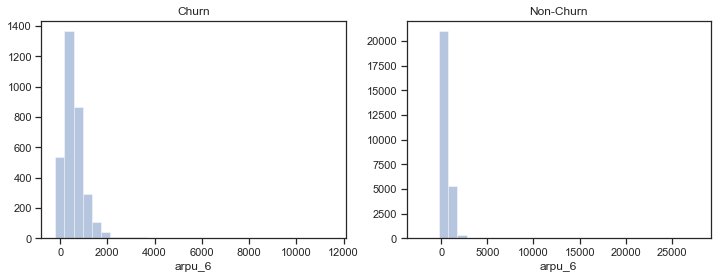

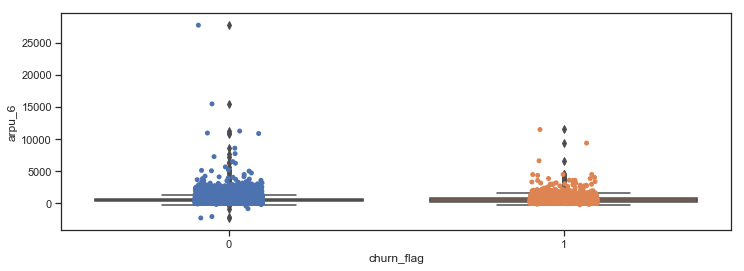

In [43]:
sub_plot(data,'arpu_6')

### onnet_mou (On network/ within the same network usage)

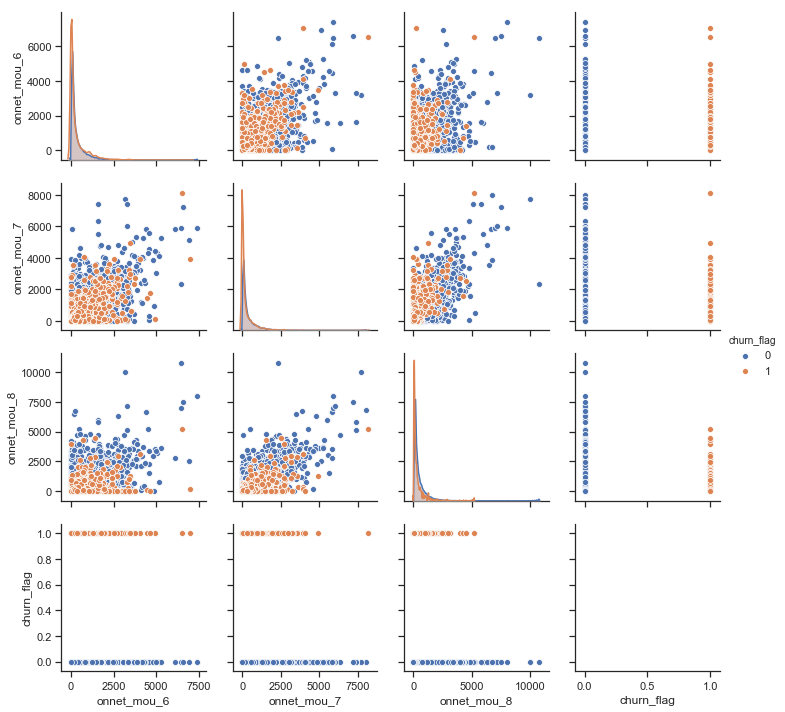

In [44]:
pair_plot(data,['onnet_mou_6','onnet_mou_7','onnet_mou_8','churn_flag'])

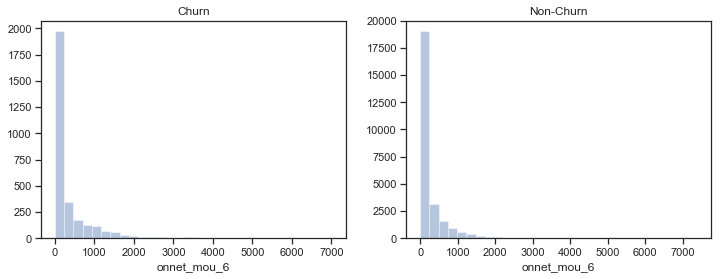

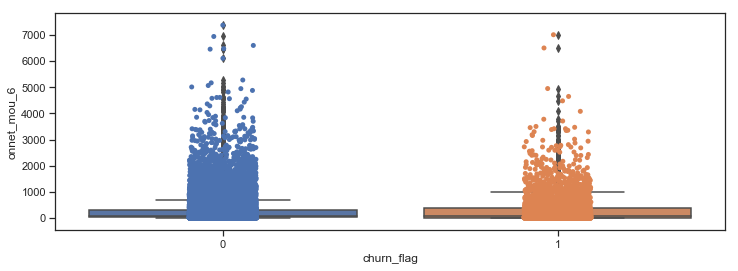

In [45]:
sub_plot(data,'onnet_mou_6')

### Offnet_mou (Calls outside of the operator network)

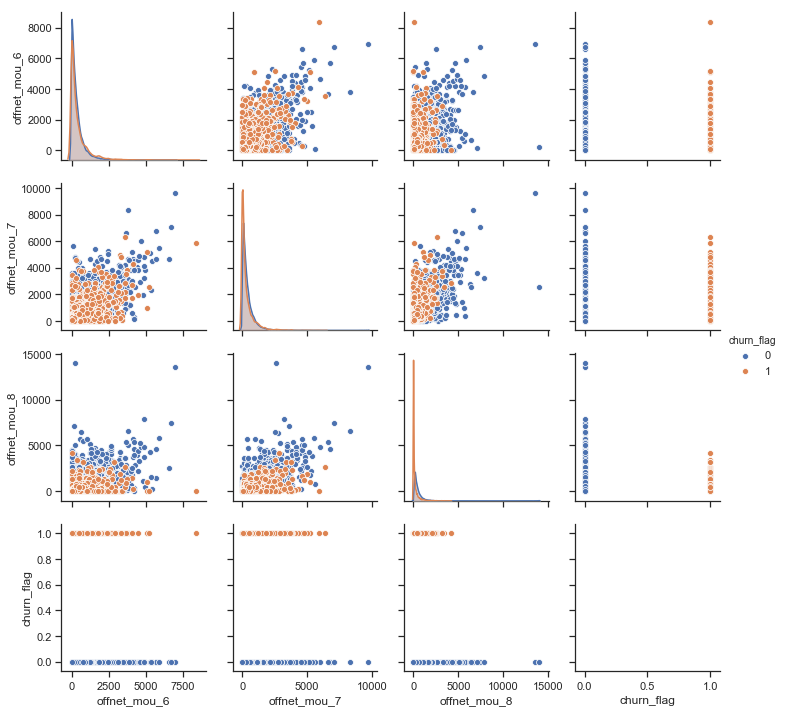

In [46]:
pair_plot(data,['offnet_mou_6','offnet_mou_7','offnet_mou_8','churn_flag'])

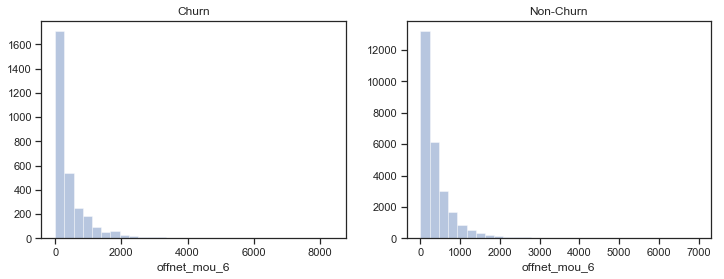

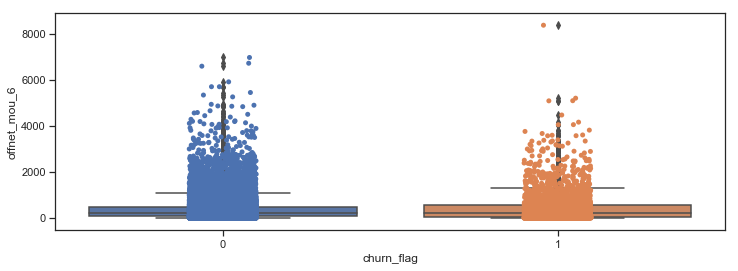

In [47]:
sub_plot(data,'offnet_mou_6')

### roam_ic_mou (Customer in roaming zone)

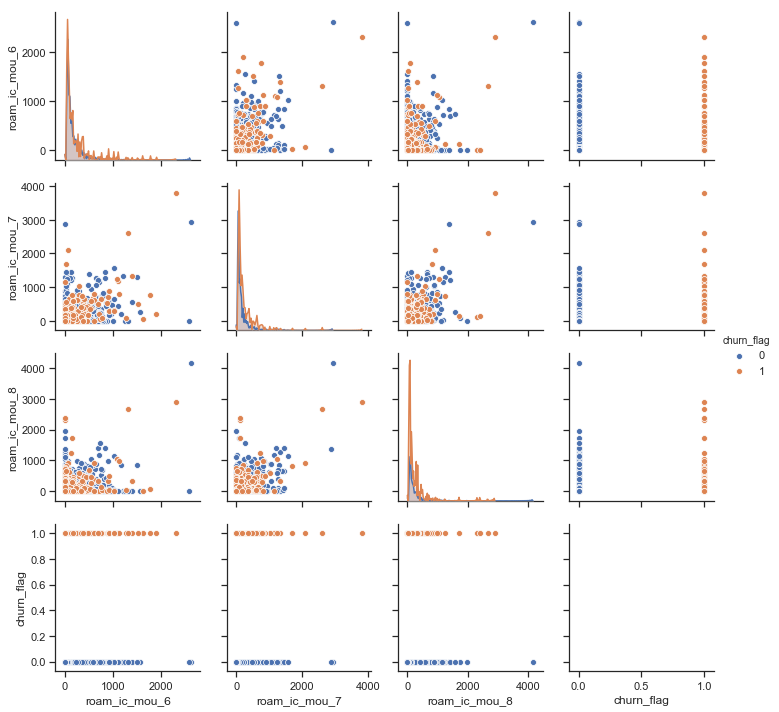

In [48]:
pair_plot(data,['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','churn_flag'])

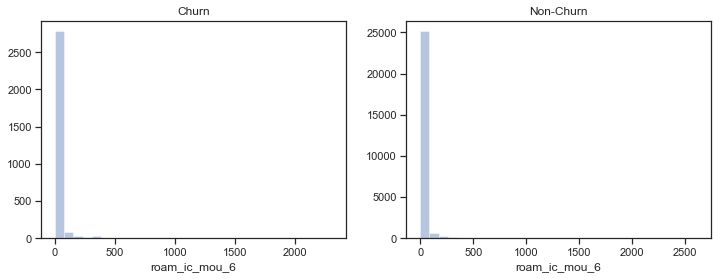

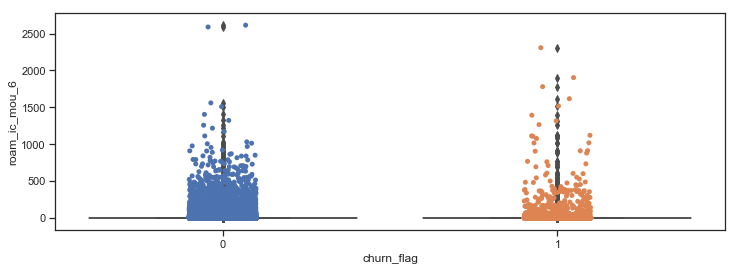

In [49]:
sub_plot(data,'roam_ic_mou_6')

### loc_og_mou (within the circle outgoing calls)

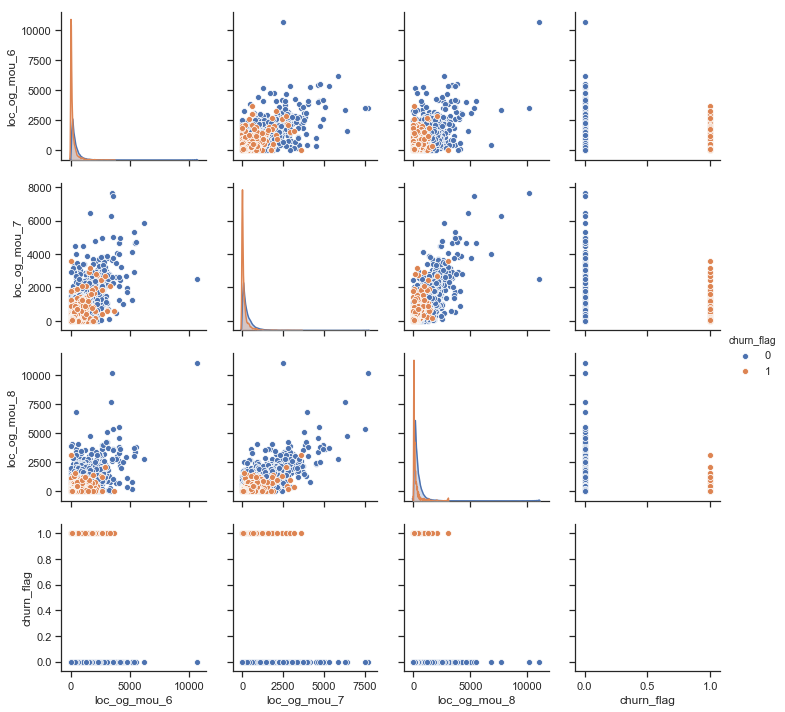

In [50]:
pair_plot(data,['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','churn_flag'])

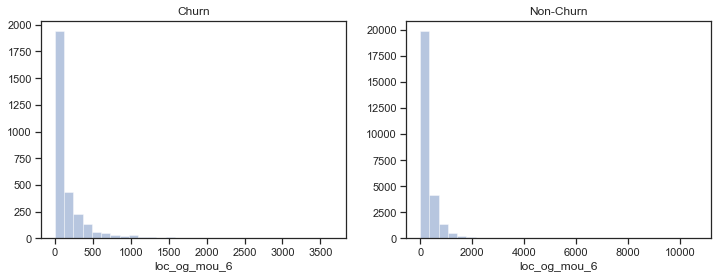

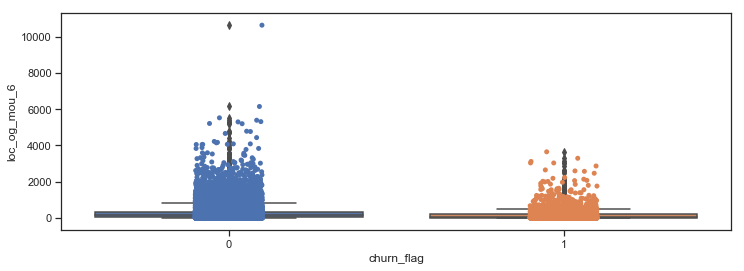

In [51]:
sub_plot(data,'loc_og_mou_6')

### std_og_mou (Outside calling circle/zone calls)

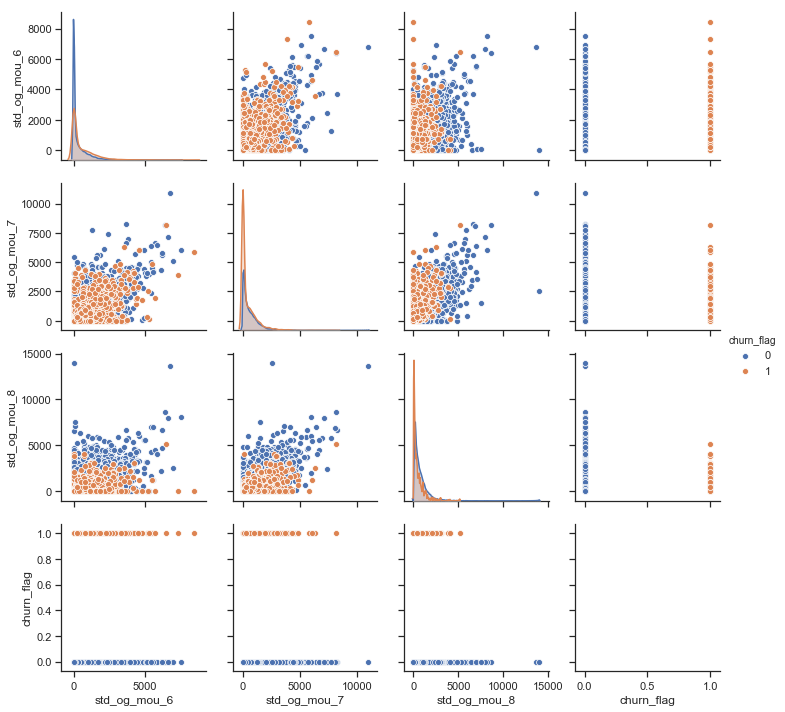

In [52]:
pair_plot(data,['std_og_mou_6','std_og_mou_7','std_og_mou_8','churn_flag'])

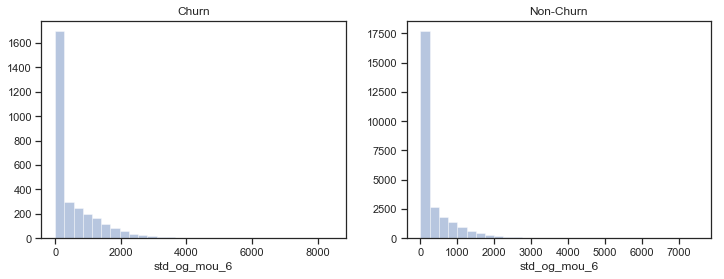

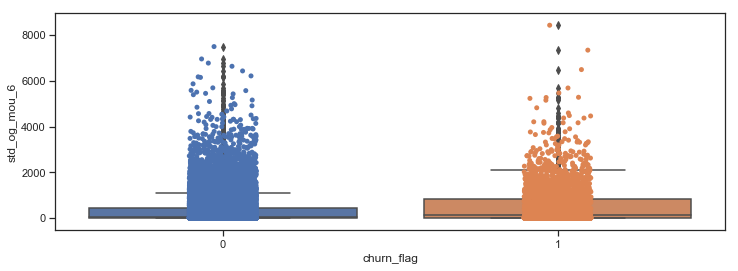

In [53]:
sub_plot(data,'std_og_mou_6')

### isd_og (international calling)

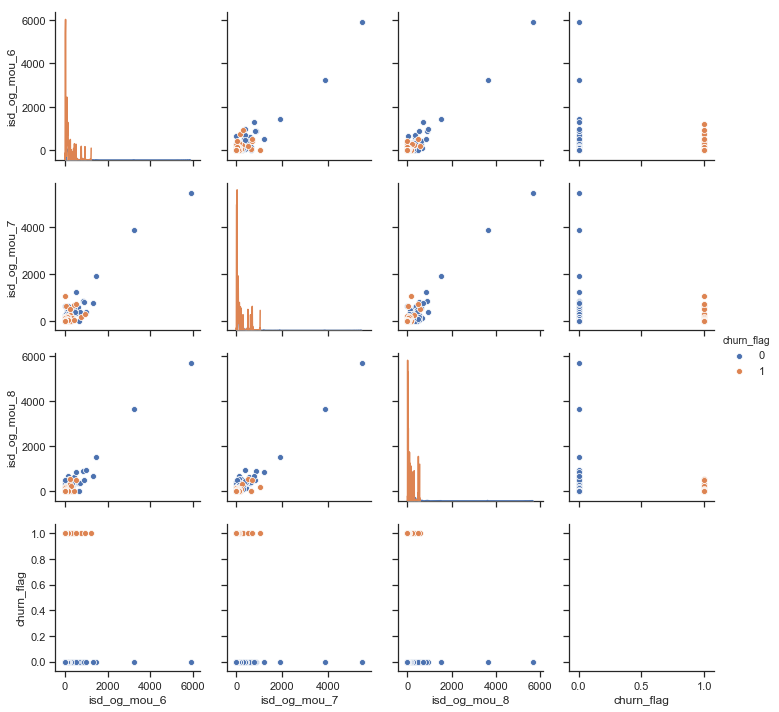

In [54]:
pair_plot(data,['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','churn_flag'])

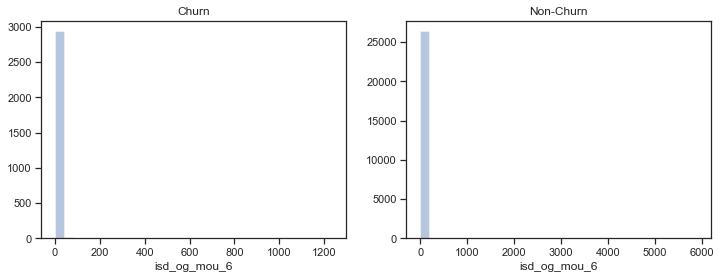

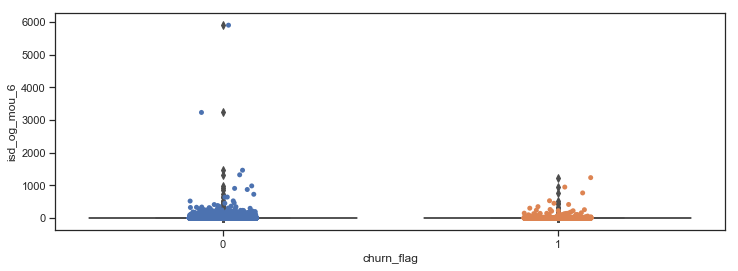

In [55]:
sub_plot(data,'isd_og_mou_6')

### totalog (All outgoing calls by the customer)

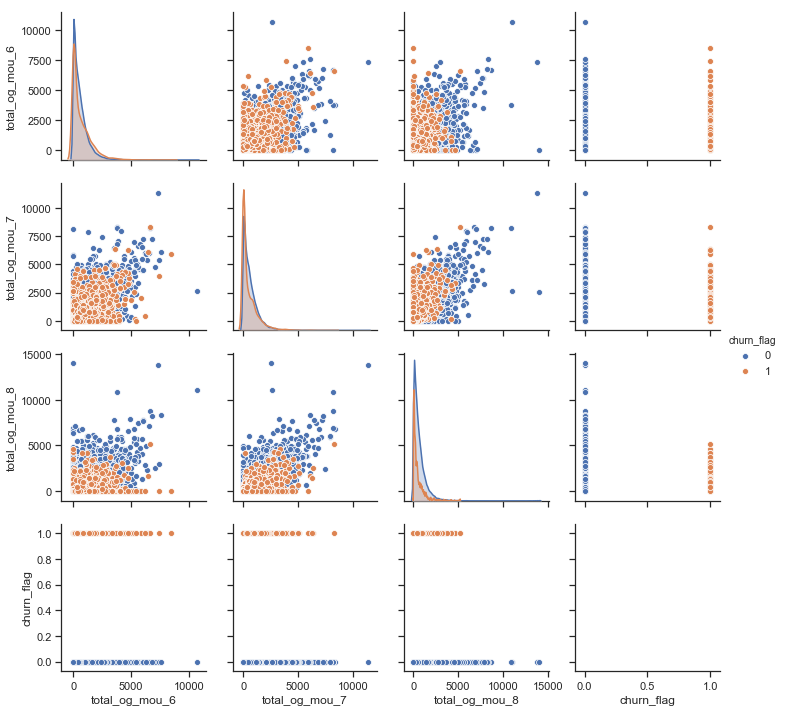

In [56]:
pair_plot(data,['total_og_mou_6','total_og_mou_7','total_og_mou_8','churn_flag'])

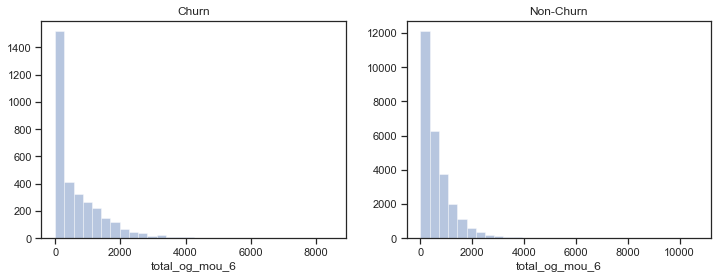

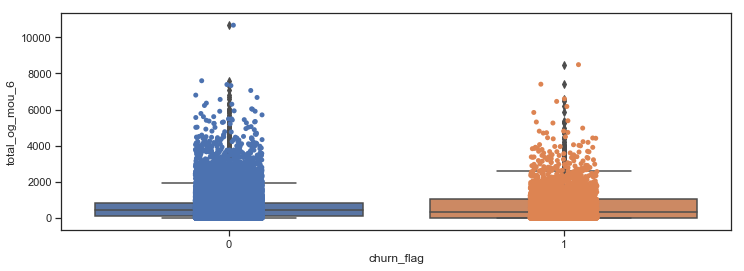

In [57]:
sub_plot(data,'total_og_mou_6')

### locic (incoming local calls)

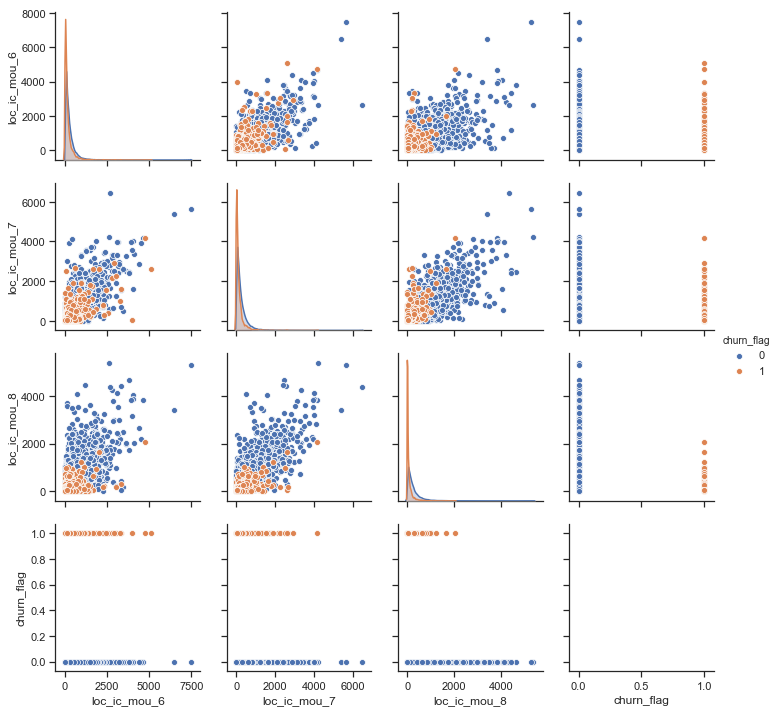

In [58]:
pair_plot(data,['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','churn_flag'])

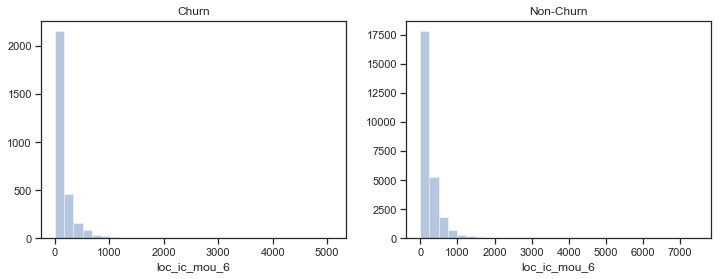

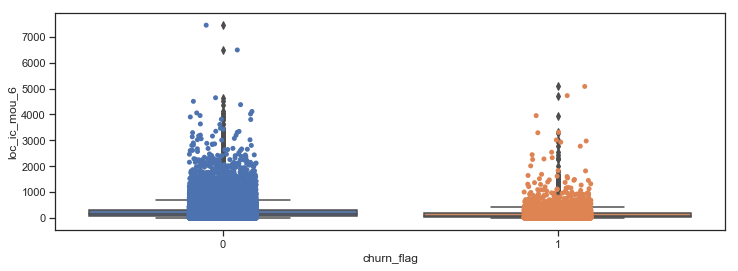

In [59]:
sub_plot(data,'loc_ic_mou_6')

### mstdic (Outside circle incoming calls)

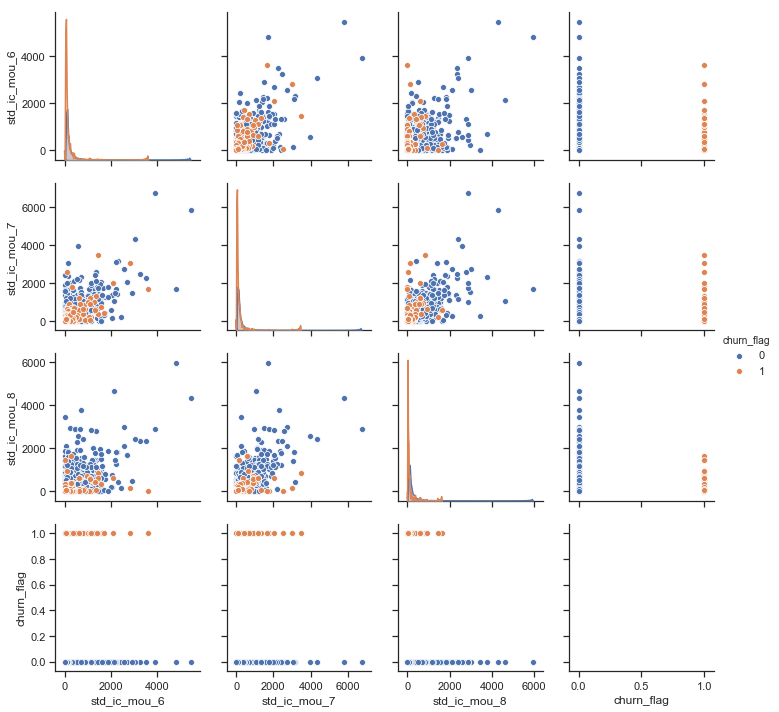

In [60]:
pair_plot(data,['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','churn_flag'])

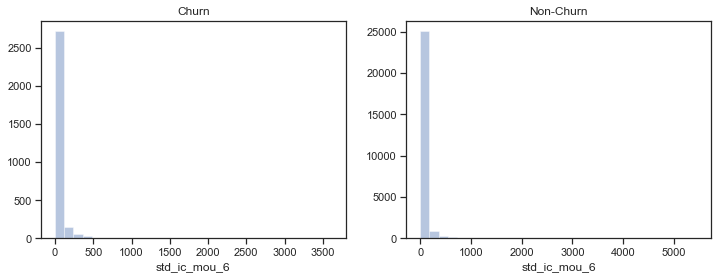

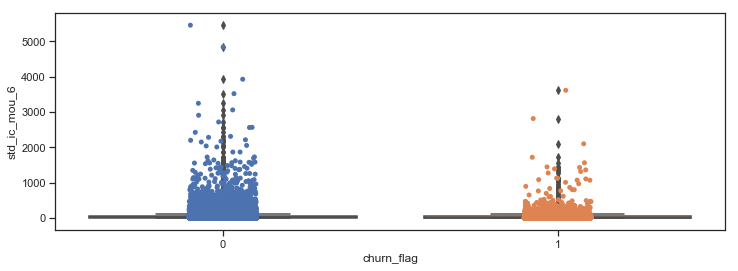

In [61]:
sub_plot(data,'std_ic_mou_6')

### totalic (All incoming calls received by a person)

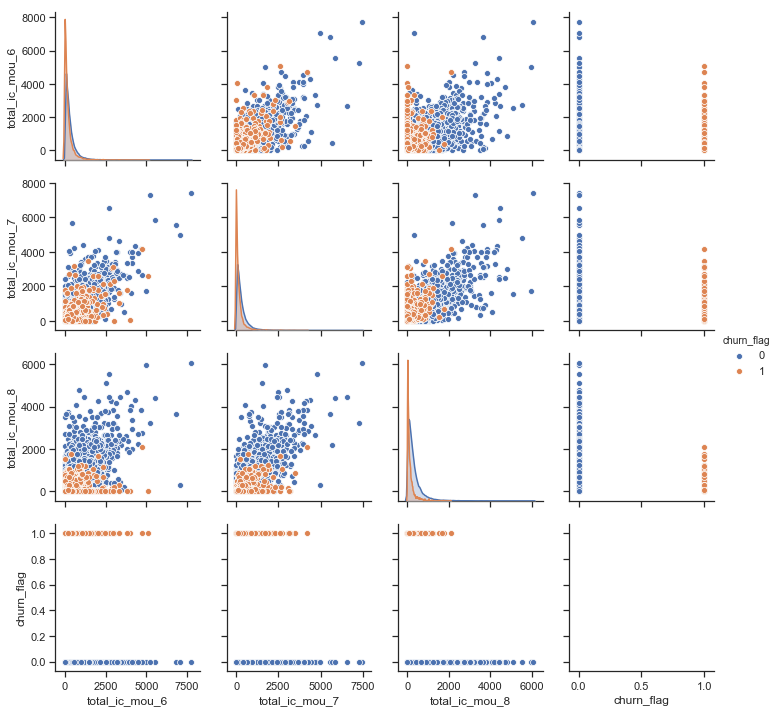

In [62]:
pair_plot(data,['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','churn_flag'])

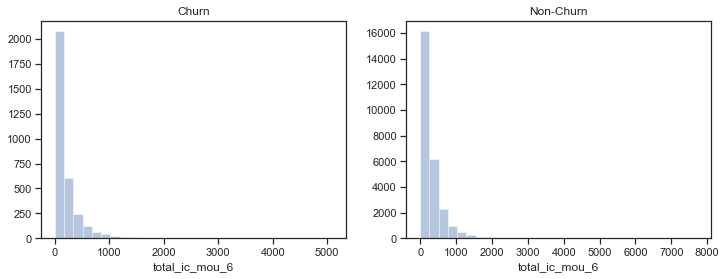

In [63]:
sub_plot(data,'total_ic_mou_6')

### total_rechnum (Number of times a subscriber recharged his mobile)

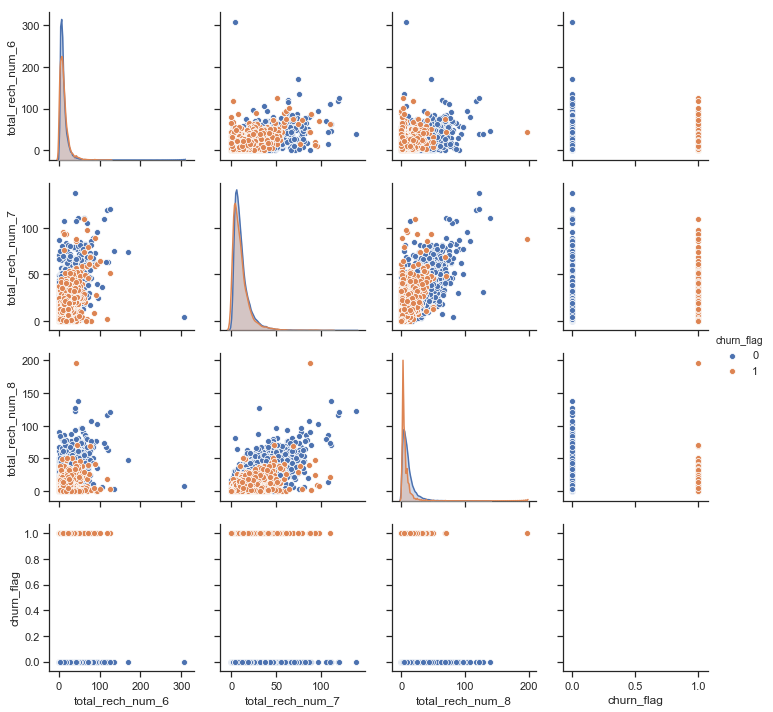

In [64]:
pair_plot(data,['total_rech_num_6','total_rech_num_7','total_rech_num_8','churn_flag'])

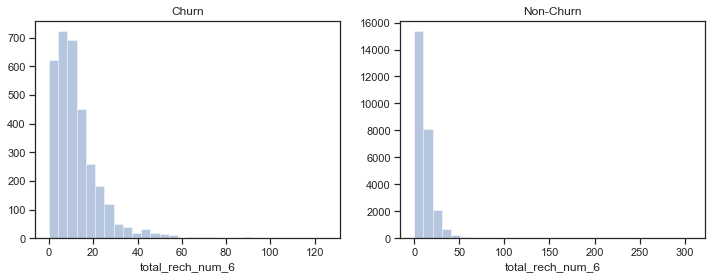

In [65]:
sub_plot(data,'total_rech_num_6')

### total_rechamt (Total recharge amount in a particular month)

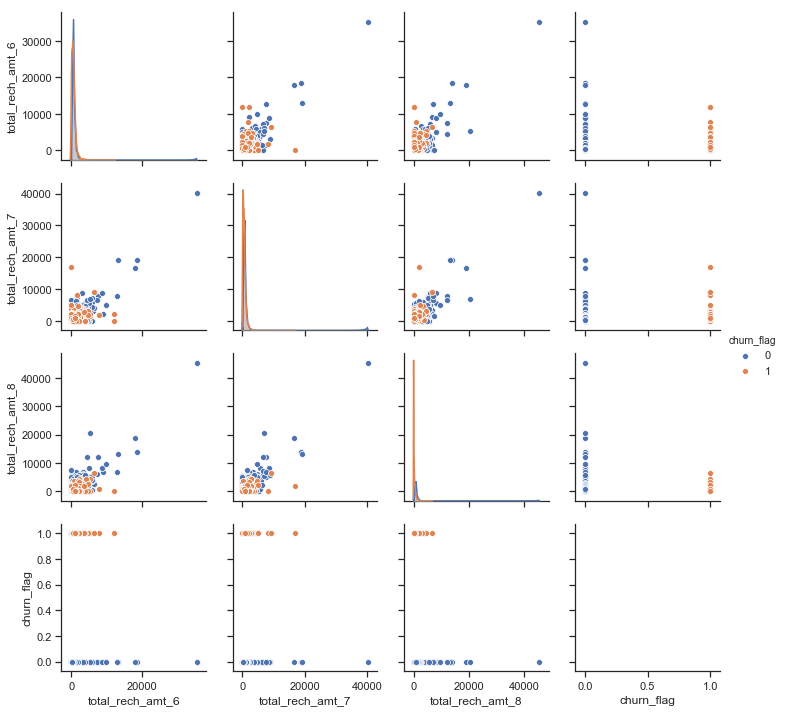

In [66]:
pair_plot(data,['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','churn_flag'])

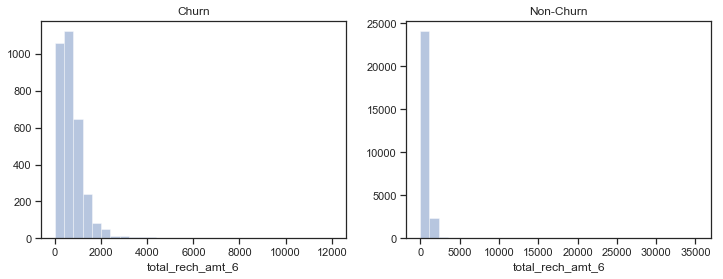

In [67]:
sub_plot(data,'total_rech_amt_6')

### total_rechdata (Total number of times mobile data has been recharged)

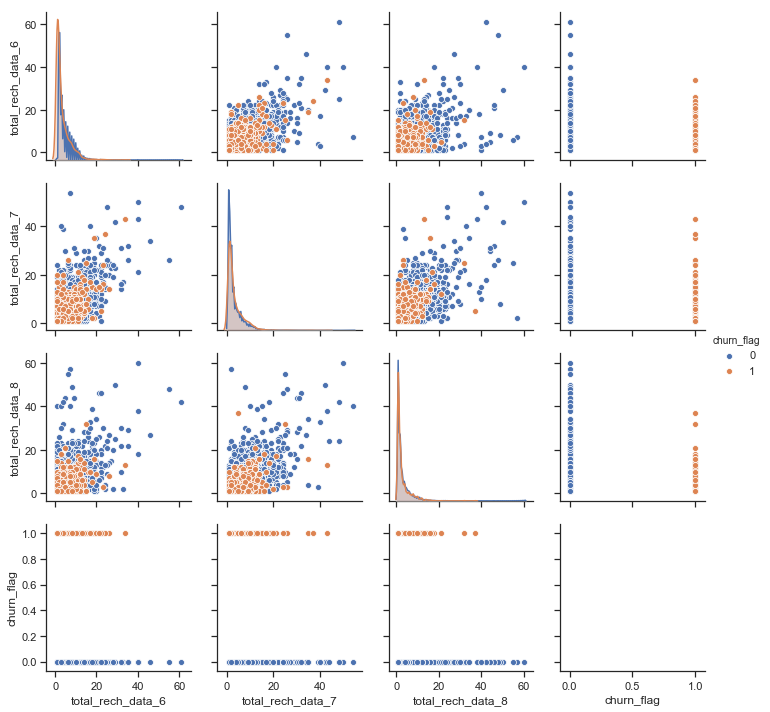

In [68]:
pair_plot(data,['total_rech_data_6','total_rech_data_7','total_rech_data_8','churn_flag'])

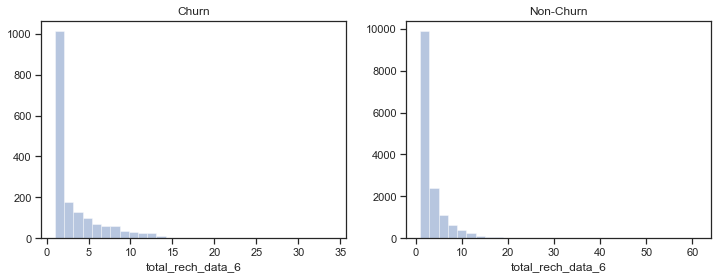

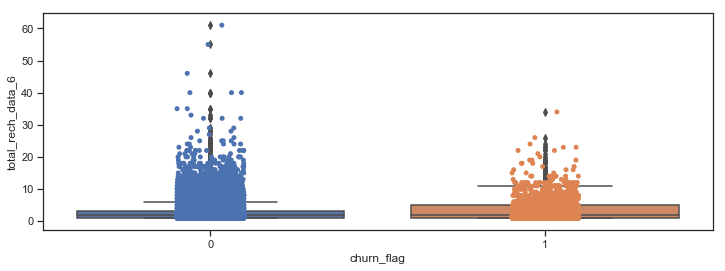

In [69]:
sub_plot(data,'total_rech_data_6')

### vol_2gmb (Internet usage in MB)

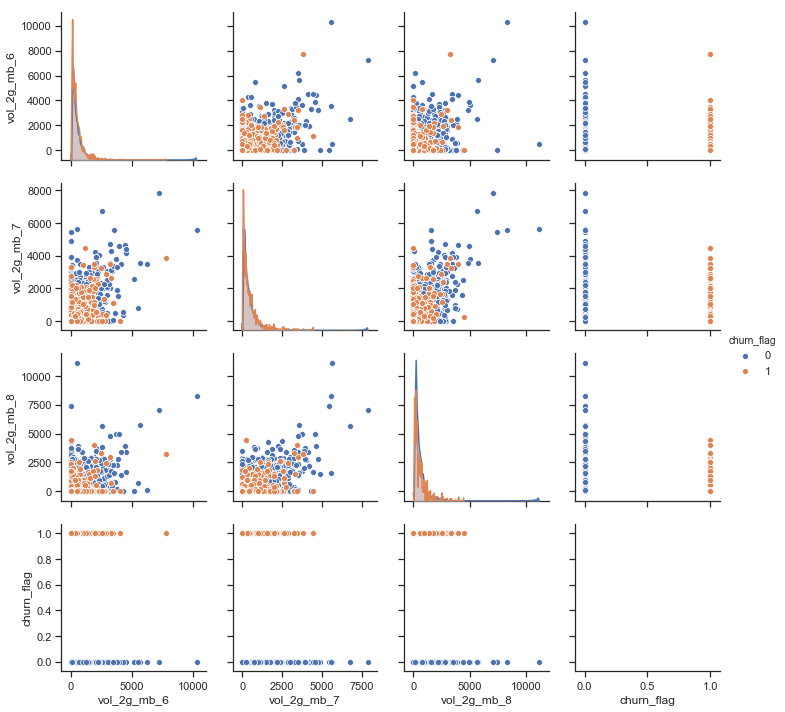

In [70]:
pair_plot(data,['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','churn_flag'])

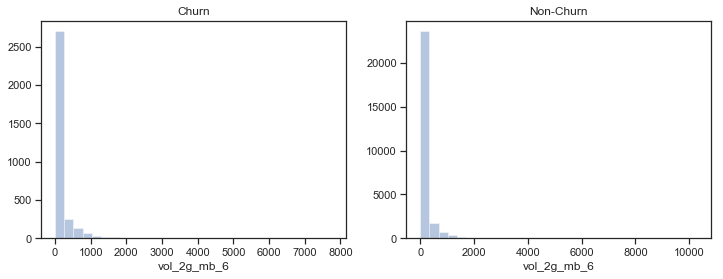

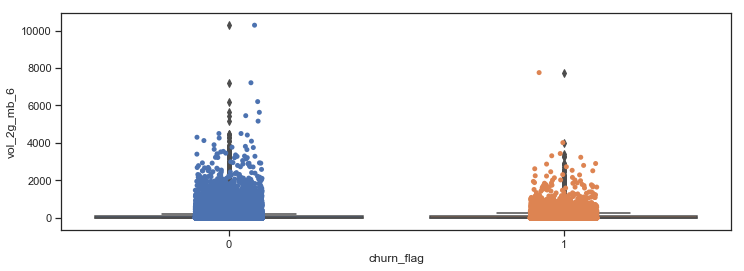

In [71]:
sub_plot(data,'vol_2g_mb_6')

### vol_3gmb (Internet usage in MB)

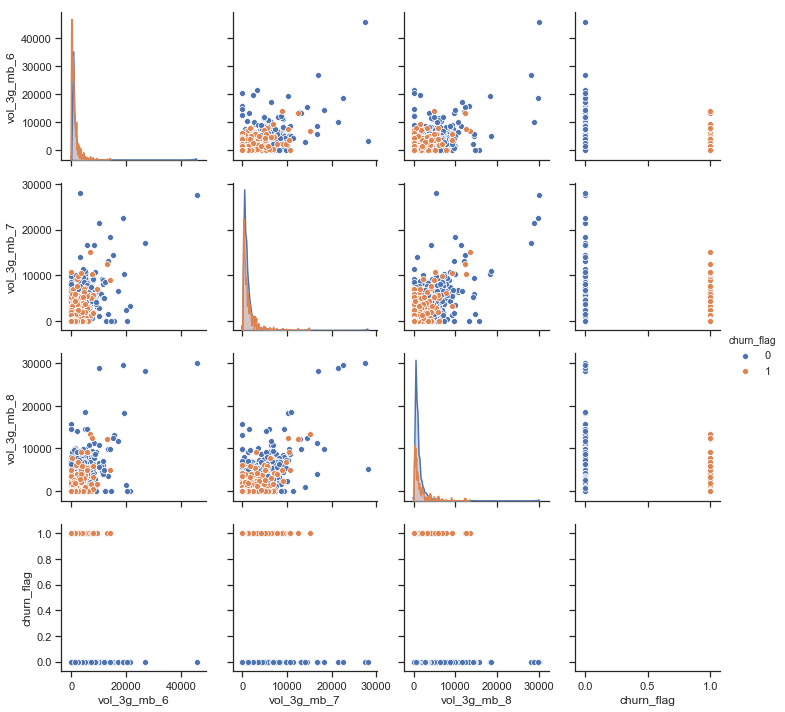

In [72]:
pair_plot(data,['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','churn_flag'])

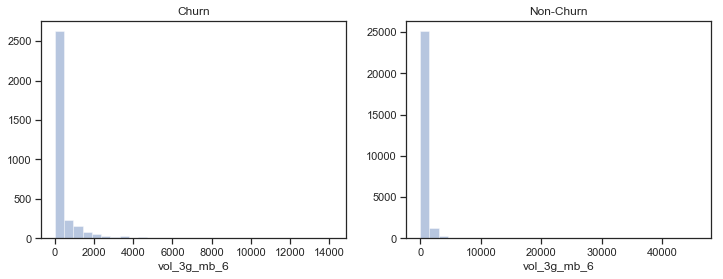

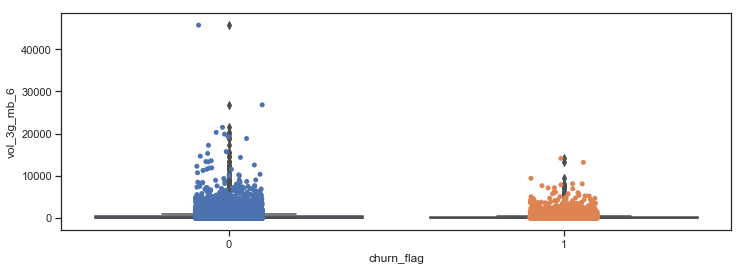

In [73]:
sub_plot(data,'vol_3g_mb_6')

### vbc3g (Volume based cost - paid as per usage)

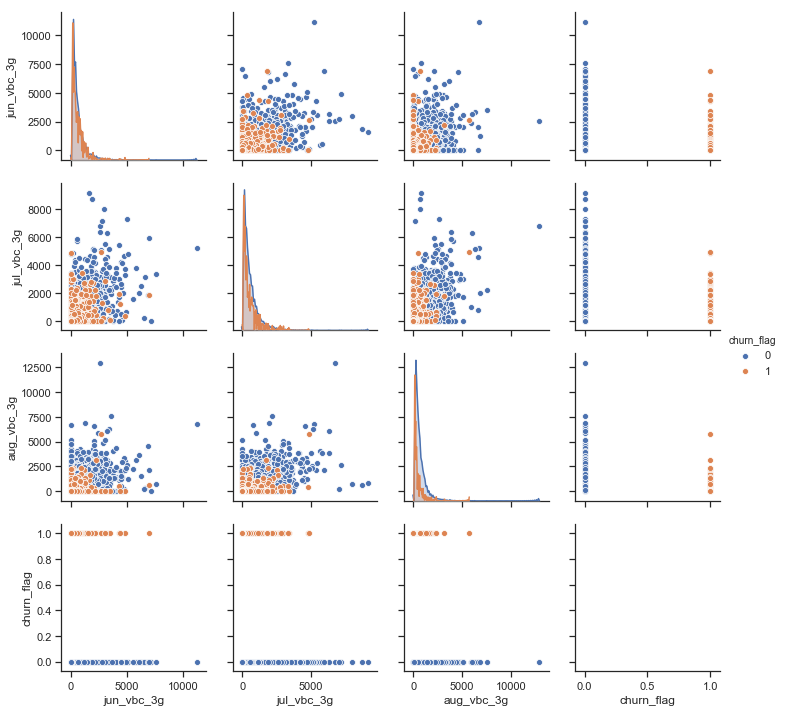

In [74]:
pair_plot(data,['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g','churn_flag'])

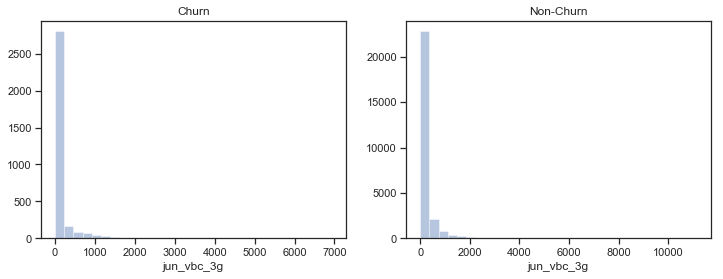

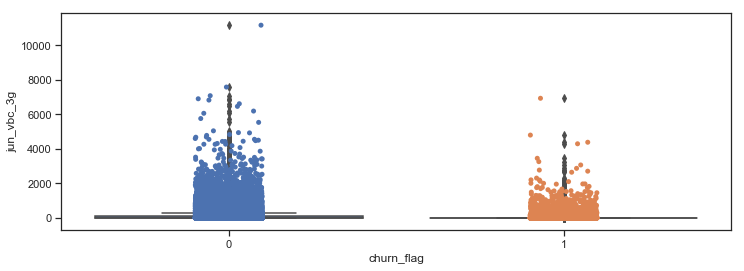

In [75]:
sub_plot(data,'jun_vbc_3g')

We can see few observations across the features, which have a different behavior. Can we consider them as outliers? Nearly 2% to 10% are tagged as outliers based on the feature. If we check the pattern between churn vs non-churn it's same across them and also it's same across the features as well. Therefore we can't exclude them from the model point of view.

### Derived features
Let's first start formating date features

In [76]:
data['date_of_last_rech_6'] = pd.to_datetime(data['date_of_last_rech_6'])
data['date_of_last_rech_7'] = pd.to_datetime(data['date_of_last_rech_7'])
data['date_of_last_rech_8'] = pd.to_datetime(data['date_of_last_rech_8'])

data['date_of_last_rech_data_6'] = pd.to_datetime(data['date_of_last_rech_data_6'])
data['date_of_last_rech_data_7'] = pd.to_datetime(data['date_of_last_rech_data_7'])
data['date_of_last_rech_data_8'] = pd.to_datetime(data['date_of_last_rech_data_8'])

data['mobile_number'] = data['mobile_number'].astype(str)

Create new features from the date columns
This may help us identifying if a particular day in a month or a week causing any issue

Now let's create new features from date column

In [77]:
data['date_of_last_rech_day_6'] = data['date_of_last_rech_6'].dt.day
data['date_of_last_rech_dayofwk_6'] = data['date_of_last_rech_6'].dt.dayofweek.astype(str)

data['date_of_last_rech_day_7'] = data['date_of_last_rech_7'].dt.day
data['date_of_last_rech_dayofwk_7'] = data['date_of_last_rech_7'].dt.dayofweek.astype(str)

data['date_of_last_rech_day_8'] = data['date_of_last_rech_8'].dt.day
data['date_of_last_rech_dayofwk_8'] = data['date_of_last_rech_8'].dt.dayofweek.astype(str)

data['date_of_last_rech_data_day_6'] = data['date_of_last_rech_data_6'].dt.day
data['date_of_last_rech_data_dayofwk_6'] = data['date_of_last_rech_data_6'].dt.dayofweek.astype(str)

data['date_of_last_rech_data_day_7'] = data['date_of_last_rech_data_7'].dt.day
data['date_of_last_rech_data_dayofwk_7'] = data['date_of_last_rech_data_7'].dt.dayofweek.astype(str)

data['date_of_last_rech_data_day_8'] = data['date_of_last_rech_data_8'].dt.day
data['date_of_last_rech_data_dayofwk_8'] = data['date_of_last_rech_data_8'].dt.dayofweek.astype(str)

In [78]:
# Let's have a look on data after feature engineering.
pd.options.display.float_format = '{:.2f}'.format
data.describe()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
count 29953.00 29953.00 29953.00     29411.00     29417.00     28781.00   
mean    558.82   561.16   508.89       265.71       272.94       243.89   
std     460.87   480.03   502.14       462.69       483.28       465.51   
min   -2258.71 -2014.05  -945.81         0.00         0.00         0.00   
25%     310.14   310.07   231.62        19.25        18.18        14.28   
50%     482.35   481.50   427.60        88.14        86.89        72.99   
75%     700.24   698.83   661.75       297.49       298.38       255.31   
max   27731.09 35145.83 33543.62      7376.71      8157.78     10752.56   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
count      29411.00      29417.00      28781.00       29411.00       29417.00   
mean         380.69        385.12        348.77          16.42          12.88   
std          484.44        501.02        486.84          77.01          76.50   
min            0.00          0.00          0.00           0.00           0.00   
25%           78.55         76.18         58.76           0.00           0.00   
50%          229.63        227.13        197.69           0.00           0.00   
75%          494.75        500.48        455.44           0.00           0.00   
max         8362.36       9667.13      14007.34        2613.31        3813.29   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
count       28781.00       29411.00       29417.00       28781.00   
mean           13.02          27.09          20.52          20.70   
std            75.63         117.28          96.97         106.83   
min             0.00           0.00           0.00           0.00   
25%             0.00           0.00           0.00           0.00   
50%             0.00           0.00           0.00           0.00   
75%             0.00           0.00           0.00           0.00   
max          4169.81        3775.11        2812.04        5337.04   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
count          29411.00          29417.00          28781.00          29411.00   
mean              86.13             87.33             81.34            166.32   
std              230.77            242.60            231.57            251.52   
min                0.00              0.00              0.00              0.00   
25%                5.03              5.29              3.84             21.13   
50%               25.59             25.79             23.26             80.34   
75%               79.87             80.44             76.11            212.49   
max             6431.33           7400.66          10752.56           4729.74   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
count          29417.00          28781.00          29411.00          29417.00   
mean             166.06            157.99              6.47              6.54   
std              242.86            236.40             22.33             22.14   
min                0.00              0.00              0.00              0.00   
25%               22.94             17.58              0.00              0.00   
50%               81.74             74.66              0.11              0.21   
75%              211.81            205.88              4.38              4.54   
max             4557.14           4961.33           1466.03           1196.43   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
count          28781.00          29411.00          29417.00          28781.00   
mean               6.13              1.61              1.92              1.77   
std               19.87              6.36              9.22              7.28   
min                0.00              0.00              0.00              0.00   
25%                0.00              0.00              0.00              0.00   
50%                0.00           

Let's check the correlation between features

In [79]:
joincorr = data.corr()
df_corr = joincorr.stack().reset_index().sort_values(by = 0, ascending = False)
df_corr[((df_corr[0] < 1) & (df_corr[0] >= 0.4)) | ((df_corr[0] <= -0.4) & (df_corr[0] > -1))]

level_0                       level_1     0
22441                   sachet_2g_8               count_rech_2g_8  0.99
18067               count_rech_2g_8                   sachet_2g_8  0.99
17903               count_rech_2g_7                   sachet_2g_7  0.99
22277                   sachet_2g_7               count_rech_2g_7  0.99
22113                   sachet_2g_6               count_rech_2g_6  0.98
17739               count_rech_2g_6                   sachet_2g_6  0.98
25254                    amt_data_7             total_data_rech_7  0.97
24930             total_data_rech_7                    amt_data_7  0.97
25090                    amt_data_6             total_data_rech_6  0.97
24766             total_data_rech_6                    amt_data_6  0.97
15487              total_rech_amt_8                        arpu_8  0.96
421                          arpu_8              total_rech_amt_8  0.96
6890                   isd_og_mou_6                  isd_og_mou_8  0.95
7214                   isd_og_mou_8                  isd_og_mou_6  0.95
7215                   isd_og_mou_8                  isd_og_mou_7  0.95
7053                   isd_og_mou_7                  isd_og_mou_8  0.95
15159              total_rech_amt_6                        arpu_6  0.95
93                           arpu_6              total_rech_amt_6  0.95
15323              total_rech_amt_7                        arpu_7  0.94
257                          arpu_7              total_rech_amt_7  0.94
6889                   isd_og_mou_6                  isd_og_mou_7  0.93
7051                   isd_og_mou_7                  isd_og_mou_6  0.93
20661                     arpu_2g_6                     arpu_3g_6  0.93
20175                     arpu_3g_6                     arpu_2g_6  0.93
20989                     arpu_2g_8                     arpu_3g_8  0.93
20503                     arpu_3g_8                     arpu_2g_8  0.93
20339                     arpu_3g_7                     arpu_2g_7  0.93
20825                     arpu_2g_7                     arpu_3g_7  0.93
10347                  loc_ic_mou_6                total_ic_mou_6  0.90
12777                total_ic_mou_6                  loc_ic_mou_6  0.90
22107                   sachet_2g_6             total_rech_data_6  0.90
16761             total_rech_data_6                   sachet_2g_6  0.90
10675                  loc_ic_mou_8                total_ic_mou_8  0.89
13105                total_ic_mou_8                  loc_ic_mou_8  0.89
16925             total_rech_data_7                   sachet_2g_7  0.89
22271                   sachet_2g_7             total_rech_data_7  0.89
17706               count_rech_2g_6             total_rech_data_6  0.89
16734             total_rech_data_6               count_rech_2g_6  0.89
17870               count_rech_2g_7             total_rech_data_7  0.89
16898             total_rech_data_7               count_rech_2g_7  0.89
17089             total_rech_data_8                   sachet_2g_8  0.89
22435                   sachet_2g_8             total_rech_data_8  0.89
12941                total_ic_mou_7                  loc_ic_mou_7  0.88
10511                  loc_ic_mou_7                total_ic_mou_7  0.88
18034               count_rech_2g_8             total_rech_data_8  0.88
17062             total_rech_data_8               count_rech_2g_8  0.88
23422                   sachet_3g_8               count_rech_3g_8  0.88
18562               count_rech_3g_8                   sachet_3g_8  0.88
847                     onnet_mou_8              std_og_t2t_mou_8  0.86
5221               std_og_t2t_mou_8                   onnet_mou_8  0.86
683                     onnet_mou_7              std_og_t2t_mou_7  0.86
5057               std_og_t2t_mou_7                   onnet_mou_7  0.86
519                     onnet_mou_6              std_og_t2t_mou_6  0.86
4893               std_og_t2t_mou_6                   onnet_mou_6  0.86
23258                   sachet_3g_7               count_rech_3g_7  0

From the above we can notice high correlation between same features and only month differs.

Let's create new features from good month and compare them with action phase

In [80]:
data['avg_arpu_6_7'] = data[['arpu_6','arpu_7']].mean(axis=1)
data['is_arpu_flag'] = flag(data,'arpu_8','avg_arpu_6_7')

data['avg_onnet_mou_6_7'] = data[['onnet_mou_6','onnet_mou_7']].mean(axis=1)
data['is_onnet_mou_flag'] = flag(data,'onnet_mou_8','avg_onnet_mou_6_7')

data['avg_offnet_mou_6_7'] = data[['offnet_mou_6','offnet_mou_7']].mean(axis=1)
data['is_offnet_mou_flag'] = flag(data,'offnet_mou_8','avg_offnet_mou_6_7')

data['avg_roam_ic_mou_6_7'] = data[['roam_ic_mou_6','roam_ic_mou_7']].mean(axis=1)
data['is_roam_ic_mou_flag'] = flag(data,'roam_ic_mou_8','avg_roam_ic_mou_6_7')

data['avg_roam_og_mou_6_7'] = data[['roam_og_mou_6','roam_og_mou_7']].mean(axis=1)
data['is_roam_og_mou_flag'] = flag(data,'roam_og_mou_8','avg_roam_og_mou_6_7')

data['avg_loc_og_t2t_mou_6_7'] = data[['loc_og_t2t_mou_6','loc_og_t2t_mou_7']].mean(axis=1)
data['is_loc_og_t2t_mou_flag'] = flag(data,'loc_og_t2t_mou_8','avg_loc_og_t2t_mou_6_7')

data['avg_loc_og_t2m_mou_6_7'] = data[['loc_og_t2m_mou_6','loc_og_t2m_mou_7']].mean(axis=1)
data['is_loc_og_t2m_mou_flag'] = flag(data,'loc_og_t2m_mou_8','avg_loc_og_t2m_mou_6_7')

data['avg_loc_og_t2f_mou_6_7'] = data[['loc_og_t2f_mou_6','loc_og_t2f_mou_7']].mean(axis=1)
data['is_loc_og_t2f_mou_flag'] = flag(data,'loc_og_t2f_mou_8','avg_loc_og_t2f_mou_6_7')

data['avg_loc_og_t2c_mou_6_7'] = data[['loc_og_t2c_mou_6','loc_og_t2c_mou_7']].mean(axis=1)
data['is_loc_og_t2c_mou_flag'] = flag(data,'loc_og_t2c_mou_8','avg_loc_og_t2c_mou_6_7')

data['avg_std_og_t2t_mou_6_7'] = data[['std_og_t2t_mou_6','std_og_t2t_mou_7']].mean(axis=1)
data['is_std_og_t2t_mou_flag'] = flag(data,'std_og_t2t_mou_8','avg_std_og_t2t_mou_6_7')

data['avg_std_og_t2m_mou_6_7'] = data[['std_og_t2m_mou_6','std_og_t2m_mou_7']].mean(axis=1)
data['is_std_og_t2m_mou_flag'] = flag(data,'std_og_t2m_mou_8','avg_std_og_t2m_mou_6_7')

data['avg_std_og_t2f_mou_6_7'] = data[['std_og_t2f_mou_6','std_og_t2f_mou_7']].mean(axis=1)
data['is_std_og_t2f_mou_flag'] = flag(data,'std_og_t2f_mou_8','avg_std_og_t2f_mou_6_7')

data['avg_isd_og_mou_6_7'] = data[['isd_og_mou_6','isd_og_mou_7']].mean(axis=1)
data['is_isd_og_mou_flag'] = flag(data,'isd_og_mou_8','avg_isd_og_mou_6_7')

data['avg_spl_og_mou_6_7'] = data[['spl_og_mou_6','spl_og_mou_7']].mean(axis=1)
data['is_spl_og_mou_flag'] = flag(data,'spl_og_mou_8','avg_spl_og_mou_6_7')

data['avg_og_others_6_7'] = data[['og_others_6','og_others_7']].mean(axis=1)
data['is_og_others_flag'] = flag(data,'og_others_8','avg_og_others_6_7')


data['avg_loc_ic_t2t_mou_6_7'] = data[['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7']].mean(axis=1)
data['is_loc_ic_t2t_mou_flag'] = flag(data,'loc_ic_t2t_mou_8','avg_loc_ic_t2t_mou_6_7')

data['avg_loc_ic_t2m_mou_6_7'] = data[['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7']].mean(axis=1)
data['is_loc_ic_t2m_mou_flag'] = flag(data,'loc_ic_t2m_mou_8','avg_loc_ic_t2m_mou_6_7')

data['avg_loc_ic_t2f_mou_6_7'] = data[['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7']].mean(axis=1)
data['is_loc_ic_t2f_mou_flag'] = flag(data,'loc_ic_t2f_mou_8','avg_loc_ic_t2f_mou_6_7')

data['avg_std_ic_t2t_mou_6_7'] = data[['std_ic_t2t_mou_6','std_ic_t2t_mou_7']].mean(axis=1)
data['is_std_ic_t2t_mou_flag'] = flag(data,'std_ic_t2t_mou_8','avg_std_ic_t2t_mou_6_7')

data['avg_std_ic_t2m_mou_6_7'] = data[['std_ic_t2m_mou_6','std_ic_t2m_mou_7']].mean(axis=1)
data['is_std_ic_t2m_mou_flag'] = flag(data,'std_ic_t2m_mou_8','avg_std_ic_t2m_mou_6_7')

data['avg_std_ic_t2f_mou_6_7'] = data[['std_ic_t2f_mou_6','std_ic_t2f_mou_7']].mean(axis=1)
data['is_std_ic_t2f_mou_flag'] = flag(data,'std_ic_t2f_mou_8','avg_std_ic_t2f_mou_6_7')

data['avg_spl_ic_mou_6_7'] = data[['spl_ic_mou_6','spl_ic_mou_7']].mean(axis=1)
data['is_spl_ic_mou_flag'] = flag(data,'spl_ic_mou_8','avg_spl_ic_mou_6_7')

data['avg_isd_ic_mou_6_7'] = data[['isd_ic_mou_6','isd_ic_mou_7']].mean(axis=1)
data['is_isd_ic_mou_flag'] = flag(data,'isd_ic_mou_8','avg_isd_ic_mou_6_7')

data['avg_ic_others_6_7'] = data[['ic_others_6','ic_others_7']].mean(axis=1)
data['is_ic_others_flag'] = flag(data,'ic_others_8','avg_ic_others_6_7')

data['avg_total_rech_amt_6_7'] = data[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1)
data['is_total_rech_amt_flag'] = flag(data,'total_rech_amt_8','avg_total_rech_amt_6_7')

data['avg_vol_2g_mb_6_7'] = data[['vol_2g_mb_6','vol_2g_mb_7']].mean(axis=1)
data['is_vol_2g_mb_flag'] = flag(data,'vol_2g_mb_8','avg_vol_2g_mb_6_7')

data['avg_vol_3g_mb_6_7'] = data[['vol_3g_mb_6','vol_3g_mb_7']].mean(axis=1)
data['is_vol_3g_mb_flag'] = flag(data,'vol_3g_mb_8','avg_vol_3g_mb_6_7')

data['avg_arpu_3g_6_7'] = data[['arpu_3g_6','arpu_3g_7']].mean(axis=1)
data['is_arpu_3g_flag'] = flag(data,'arpu_3g_8','avg_arpu_3g_6_7')

data['avg_arpu_2g_6_7'] = data[['arpu_2g_6','arpu_2g_7']].mean(axis=1)
data['is_arpu_2g_flag'] = flag(data,'arpu_2g_8','avg_arpu_2g_6_7')

data['avg_vbc_3g_6_7'] = data[['jun_vbc_3g','jul_vbc_3g']].mean(axis=1)
data['is_vbc_3g_flag'] = flag(data,'aug_vbc_3g','avg_vbc_3g_6_7')

data['avg_loc_og_mou_6_7'] = data[['loc_og_mou_6','loc_og_mou_7']].mean(axis=1)
data['is_loc_og_mou_flag'] = flag(data,'loc_og_mou_8','avg_loc_og_mou_6_7')

data['avg_std_og_mou_6_7'] = data[['std_og_mou_6','std_og_mou_7']].mean(axis=1)
data['is_std_og_mou_flag'] = flag(data,'std_og_mou_8','avg_std_og_mou_6_7')

data['avg_total_og_mou_6_7'] = data[['total_og_mou_6','total_og_mou_7']].mean(axis=1)
data['is_total_og_mou_flag'] = flag(data,'total_og_mou_8','avg_total_og_mou_6_7')

data['avg_loc_ic_mou_6_7'] = data[['loc_ic_mou_6','loc_ic_mou_7']].mean(axis=1)
data['is_loc_ic_mou_flag'] = flag(data,'loc_ic_mou_8','avg_loc_ic_mou_6_7')

data['avg_std_ic_mou_6_7'] = data[['std_ic_mou_6','std_ic_mou_7']].mean(axis=1)
data['is_std_ic_mou_flag'] = flag(data,'std_ic_mou_8','avg_std_ic_mou_6_7')

data['avg_total_ic_mou_6_7'] = data[['total_ic_mou_6','total_ic_mou_7']].mean(axis=1)
data['is_total_ic_mou_flag'] = flag(data,'total_ic_mou_8','avg_total_ic_mou_6_7')

data['avg_night_pck_user_6_7'] = data[['night_pck_user_6','night_pck_user_7']].mean(axis=1)
data['is_night_pck_user_flag'] = flag(data,'night_pck_user_8','avg_night_pck_user_6_7')

data['avg_monthly_2g_6_7'] = data[['monthly_2g_6','monthly_2g_7']].mean(axis=1)
data['is_monthly_2g_flag'] = flag(data,'monthly_2g_8','avg_monthly_2g_6_7')

data['avg_sachet_2g_6_7'] = data[['sachet_2g_6','sachet_2g_7']].mean(axis=1)
data['is_sachet_2g_flag'] = flag(data,'sachet_2g_8','avg_sachet_2g_6_7')

data['avg_monthly_3g_6_7'] = data[['monthly_3g_6','monthly_3g_7']].mean(axis=1)
data['is_monthly_3g_flag'] = flag(data,'monthly_3g_8','avg_monthly_3g_6_7')

data['avg_sachet_3g_6_7'] = data[['sachet_3g_6','sachet_3g_7']].mean(axis=1)
data['is_sachet_3g_flag'] = flag(data,'sachet_3g_8','avg_sachet_3g_6_7')

data['avg_fb_user_6_7'] = data[['fb_user_6','fb_user_7']].mean(axis=1)
data['is_fb_user_flag'] = flag(data,'fb_user_8','avg_fb_user_6_7')

Let's create month on month change features to undersatnd any risk associated with churn

In [81]:
data['loc_og_t2t_mou_7diff6'] = diff(data,'loc_og_t2t_mou_7','loc_og_t2t_mou_6')
data['loc_og_t2m_mou_7diff6'] = diff(data,'loc_og_t2m_mou_7','loc_og_t2m_mou_6')
data['loc_og_t2f_mou_7diff6'] = diff(data,'loc_og_t2f_mou_7','loc_og_t2f_mou_6')
data['loc_og_t2c_mou_7diff6'] = diff(data,'loc_og_t2c_mou_7','loc_og_t2c_mou_6')
data['loc_og_mou_7diff6']     = diff(data,'loc_og_mou_7','loc_og_mou_6')
data['std_og_t2t_mou_7diff6'] = diff(data,'std_og_t2t_mou_7','std_og_t2t_mou_6')
data['std_og_t2m_mou_7diff6'] = diff(data,'std_og_t2m_mou_7','std_og_t2m_mou_6')
data['std_og_t2f_mou_7diff6'] = diff(data,'std_og_t2f_mou_7','std_og_t2f_mou_6')
data['std_og_mou_7diff6']     = diff(data,'std_og_mou_7','std_og_mou_6')
data['loc_og_mou_7diff6']     = diff(data,'loc_og_mou_7','loc_og_mou_6')
data['std_og_mou_7diff6']     = diff(data,'std_og_mou_7','std_og_mou_6')
data['isd_og_mou_7diff6']     = diff(data,'isd_og_mou_7','isd_og_mou_6')
data['spl_og_mou_7diff6']     = diff(data,'spl_og_mou_7','spl_og_mou_6')
data['og_others_7diff6']      = diff(data,'og_others_7','og_others_6')
data['total_og_mou_7diff6']   = diff(data,'total_og_mou_7','total_og_mou_6')

data['loc_og_t2t_mou_8diff7'] = diff(data,'loc_og_t2t_mou_8','loc_og_t2t_mou_7')
data['loc_og_t2m_mou_8diff7'] = diff(data,'loc_og_t2m_mou_8','loc_og_t2m_mou_7')
data['loc_og_t2f_mou_8diff7'] = diff(data,'loc_og_t2f_mou_8','loc_og_t2f_mou_7')
data['loc_og_t2c_mou_8diff7'] = diff(data,'loc_og_t2c_mou_8','loc_og_t2c_mou_7')
data['loc_og_mou_8diff7']     = diff(data,'loc_og_mou_8','loc_og_mou_7')
data['std_og_t2t_mou_8diff7'] = diff(data,'std_og_t2t_mou_8','std_og_t2t_mou_7')
data['std_og_t2m_mou_8diff7'] = diff(data,'std_og_t2m_mou_8','std_og_t2m_mou_7')
data['std_og_t2f_mou_8diff7'] = diff(data,'std_og_t2f_mou_8','std_og_t2f_mou_7')
data['std_og_mou_8diff7']     = diff(data,'std_og_mou_8','std_og_mou_7')
data['loc_og_mou_8diff7']     = diff(data,'loc_og_mou_8','loc_og_mou_7')
data['std_og_mou_8diff7']     = diff(data,'std_og_mou_8','std_og_mou_7')
data['isd_og_mou_8diff7']     = diff(data,'isd_og_mou_8','isd_og_mou_7')
data['spl_og_mou_8diff7']     = diff(data,'spl_og_mou_8','spl_og_mou_7')
data['og_others_8diff7']      = diff(data,'og_others_8','og_others_7')
data['total_og_mou_8diff7']   = diff(data,'total_og_mou_8','total_og_mou_7')

data['loc_ic_t2t_mou_7diff6'] = diff(data,'loc_ic_t2t_mou_7','loc_ic_t2t_mou_6')
data['loc_ic_t2m_mou_7diff6'] = diff(data,'loc_ic_t2m_mou_7','loc_ic_t2m_mou_6')
data['loc_ic_t2f_mou_7diff6'] = diff(data,'loc_ic_t2f_mou_7','loc_ic_t2f_mou_6')
data['loc_ic_mou_7diff6']     = diff(data,'loc_ic_mou_7','loc_ic_mou_6')
data['std_ic_t2t_mou_7diff6'] = diff(data,'std_ic_t2t_mou_7','std_ic_t2t_mou_6')
data['std_ic_t2m_mou_7diff6'] = diff(data,'std_ic_t2m_mou_7','std_ic_t2m_mou_6')
data['std_ic_t2f_mou_7diff6'] = diff(data,'std_ic_t2f_mou_7','std_ic_t2f_mou_6')
data['std_ic_mou_7diff6']     = diff(data,'std_ic_mou_7','std_ic_mou_6')
data['loc_ic_mou_7diff6']     = diff(data,'loc_ic_mou_7','loc_ic_mou_6')
data['std_ic_mou_7diff6']     = diff(data,'std_ic_mou_7','std_ic_mou_6')
data['spl_ic_mou_7diff6']     = diff(data,'spl_ic_mou_7','spl_ic_mou_6')
data['isd_ic_mou_7diff6']     = diff(data,'isd_ic_mou_7','isd_ic_mou_6')
data['ic_others_7diff6']      = diff(data,'ic_others_7','ic_others_6')
data['total_ic_mou_7diff6']   = diff(data,'total_ic_mou_7','total_ic_mou_6')

data['loc_ic_t2t_mou_8diff7'] = diff(data,'loc_ic_t2t_mou_8','loc_ic_t2t_mou_7')
data['loc_ic_t2m_mou_8diff7'] = diff(data,'loc_ic_t2m_mou_8','loc_ic_t2m_mou_7')
data['loc_ic_t2f_mou_8diff7'] = diff(data,'loc_ic_t2f_mou_8','loc_ic_t2f_mou_7')
data['loc_ic_mou_8diff7']     = diff(data,'loc_ic_mou_8','loc_ic_mou_7')
data['std_ic_t2t_mou_8diff7'] = diff(data,'std_ic_t2t_mou_8','std_ic_t2t_mou_7')
data['std_ic_t2m_mou_8diff7'] = diff(data,'std_ic_t2m_mou_8','std_ic_t2m_mou_7')
data['std_ic_t2f_mou_8diff7'] = diff(data,'std_ic_t2f_mou_8','std_ic_t2f_mou_7')
data['std_ic_mou_8diff7']     = diff(data,'std_ic_mou_8','std_ic_mou_7')
data['loc_ic_mou_8diff7']     = diff(data,'loc_ic_mou_8','loc_ic_mou_7')
data['std_ic_mou_8diff7']     = diff(data,'std_ic_mou_8','std_ic_mou_7')
data['spl_ic_mou_8diff7']     = diff(data,'spl_ic_mou_8','spl_ic_mou_7')
data['isd_ic_mou_8diff7']     = diff(data,'isd_ic_mou_8','isd_ic_mou_7')
data['ic_others_8diff7']      = diff(data,'ic_others_8','ic_others_7')
data['total_ic_mou_8diff7']   = diff(data,'total_ic_mou_8','total_ic_mou_7')

data['onnet_mou_7diff6']      = diff(data,'onnet_mou_7','onnet_mou_6')
data['onnet_mou_8diff7']      = diff(data,'onnet_mou_8','onnet_mou_7')

data['offnet_mou_7diff6']     = diff(data,'offnet_mou_7','offnet_mou_6')
data['offnet_mou_8diff7']     = diff(data,'offnet_mou_8','offnet_mou_7')

data['roam_ic_mou_7diff6']    = diff(data,'roam_ic_mou_7','roam_ic_mou_6')
data['roam_ic_mou_8diff7']    = diff(data,'roam_ic_mou_8','roam_ic_mou_7')

data['roam_og_mou_7diff6']    = diff(data,'roam_og_mou_7','roam_og_mou_6')
data['roam_og_mou_8diff7']    = diff(data,'roam_og_mou_8','roam_og_mou_7')

data['total_rech_amt_7diff6'] = diff(data,'total_rech_amt_7','total_rech_amt_6')
data['total_rech_amt_8diff7'] = diff(data,'total_rech_amt_8','total_rech_amt_7')

data['date_of_last_rech_7diff6'] = diff(data,'date_of_last_rech_7','date_of_last_rech_6').dt.days
data['date_of_last_rech_8diff7'] = diff(data,'date_of_last_rech_8','date_of_last_rech_7').dt.days

data['date_of_last_rech_data_7diff6'] = diff(data,'date_of_last_rech_data_7','date_of_last_rech_data_6').dt.days
data['date_of_last_rech_data_8diff7'] = diff(data,'date_of_last_rech_data_8','date_of_last_rech_data_7').dt.days

data['vol_2g_mb_7diff6'] = diff(data,'vol_2g_mb_7','vol_2g_mb_6')
data['vol_2g_mb_8diff7'] = diff(data,'vol_2g_mb_8','vol_2g_mb_7')

data['vol_3g_mb_7diff6'] = diff(data,'vol_3g_mb_7','vol_3g_mb_6')
data['vol_3g_mb_8diff7'] = diff(data,'vol_3g_mb_8','vol_3g_mb_7')

data['vbc_3g_7diff6']    = diff(data,'jul_vbc_3g','jun_vbc_3g')
data['vbc_3g_8diff7']    = diff(data,'aug_vbc_3g','jul_vbc_3g')

In [82]:
data.head()

mobile_number  arpu_6  arpu_7  arpu_8  onnet_mou_6  onnet_mou_7  \
0     7000842753  197.38  214.82  213.80          nan          nan   
7     7000701601 1069.18 1349.85 3171.48        57.84        54.68   
8     7001524846  378.72  492.22  137.36       413.69       351.03   
21    7002124215  514.45  597.75  637.76       102.41       132.11   
23    7000887461   74.35  193.90  366.97        48.96        50.66   

    onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
0          0.00           nan           nan          0.00            nan   
7         52.29        453.43        567.16        325.91          16.23   
8         35.08         94.66         80.63        136.48           0.00   
21        85.14        757.93        896.68        983.39           0.00   
23        33.58         85.41         89.36        205.89           0.00   

    roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0             nan           0.00            nan            nan           0.00   
7           33.49          31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00           0.00   
21           0.00           0.00           0.00           0.00           0.00   
23           0.00           0.00           0.00           0.00           0.00   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0                nan               nan              0.00               nan   
7              51.39             31.38             40.28            308.63   
8             297.13            217.59             12.49             80.96   
21              4.48              6.16             23.34             91.81   
23             48.96             50.66             33.58             82.94   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0                nan              0.00               nan               nan   
7             447.38            162.28             62.13             55.14   
8              70.58             50.54              0.00              0.00   
21             87.93            104.81              0.75              0.00   
23             83.01            148.56              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0               0.00               nan               nan              0.00   
7              53.23              0.00              0.00              0.00   
8               0.00              0.00              0.00              7.15   
21              1.58              0.00              0.00              0.00   
23              0.00              0.00              0.00             17.71   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0            nan           nan          0.00               nan   
7         422.16        533.91        255.79              4.30   
8         378.09        288.18         63.04            116.56   
21         97.04         94.09        129.74             97.93   
23        131.91        133.68        182.14              0.00   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0                nan              0.00               nan               nan   
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
21            125.94             61.79            665.36            808.74   
23              0.00              0.00              2.36              6.35   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.00               nan               nan              0.00   
7              49.14              6.66             20.08             16.68   
8              75.69              0.00              0.00              0.00   
21            876.99              0.00              0

### Feature Selection

__What feature selection techniques could be used to reduce the number of features?__

There are several ways for feature selection: To begin with all feature selection starts with some business domain knowledge. Variables that are relevant, available prior to modeling should be used.

Variables with no variance or single value should be eliminated. We did such an analysis of understanding the data and eliminated the variables.

Nominal data with no specific relevant to the modeling exercise can be removed- like mobile_number.

Variables like Date can be converted to numerical by extracting features like day of a week, day of a month etc.

Categorical variables have to be encoded as dummy variables

We add/delete a subset of features, train a model iteratively until the best possible model is found. Examples are:

- Forward selection
- Backward selection
- Recursive feature elimination


Embedded Methods - Embedded methods combine the qualities of both filter and wrapper methods. These Algorithms that have their own built-in feature selection methodology implement it. Examples are:

- Lasso Regression
- Ridge Regression
- Random Forest with Gini coefficient
- Gradient boosting with feature importance

In [83]:
data.shape


(29953, 330)

In [84]:
list(data.select_dtypes(include=['datetime64']).columns)

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

Let's drop date related features as we derived new features out of it

In [85]:
# Let's drop all 'datetime64' columns.
data.drop(list(data.select_dtypes(include=['datetime64']).columns),axis=1,inplace=True)

Since we have the good data for both month 6, 7 as average, we dont need the raw columns, so dropping them

In [86]:
columns = ['arpu_6','arpu_7','onnet_mou_6','onnet_mou_7','offnet_mou_6','offnet_mou_7',
         'roam_ic_mou_6','roam_ic_mou_7','roam_og_mou_6','roam_og_mou_7',
         'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2m_mou_6','loc_og_t2m_mou_7',
         'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2c_mou_6','loc_og_t2c_mou_7',
         'std_og_t2t_mou_6','std_og_t2t_mou_7', 'std_og_t2m_mou_6','std_og_t2m_mou_7',
         'std_og_t2f_mou_6','std_og_t2f_mou_7','isd_og_mou_6','isd_og_mou_7',
         'spl_og_mou_6','spl_og_mou_7', 'og_others_6','og_others_7',
         'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7',
         'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7', 'std_ic_t2t_mou_6','std_ic_t2t_mou_7',
         'std_ic_t2m_mou_6','std_ic_t2m_mou_7', 'std_ic_t2f_mou_6','std_ic_t2f_mou_7',
         'spl_ic_mou_6','spl_ic_mou_7', 'isd_ic_mou_6','isd_ic_mou_7',
         'ic_others_6','ic_others_7', 'total_rech_amt_6','total_rech_amt_7',
         'vol_2g_mb_6','vol_2g_mb_7', 'vol_3g_mb_6','vol_3g_mb_7',
         'arpu_3g_6','arpu_3g_7', 'arpu_2g_6','arpu_2g_7',
         'jun_vbc_3g','jul_vbc_3g', 'loc_og_mou_6', 'loc_og_mou_7','std_og_mou_6', 'std_og_mou_7',
          'total_og_mou_6', 'total_og_mou_7','loc_ic_mou_6', 'loc_ic_mou_7',
          'std_ic_mou_6', 'std_ic_mou_7','total_ic_mou_6', 'total_ic_mou_7',
          'total_rech_num_6', 'total_rech_num_7','night_pck_user_6', 'night_pck_user_7',
          'monthly_2g_6', 'monthly_2g_7','sachet_2g_6', 'sachet_2g_7',
          'monthly_3g_6', 'monthly_3g_7','sachet_3g_6', 'sachet_3g_7','fb_user_6', 'fb_user_7'
        ]
data.drop(columns, axis=1, inplace=True)

In [87]:
# After removing above columns , let's have a look on data dimensions
data.shape

(29953, 238)

In [88]:
# Let's calculate the correlation between the features
correlation_matrix = data.corr()
AbsoluteCorrelationMatrix = correlation_matrix.abs()
AbsoluteCorrelationMatrix = AbsoluteCorrelationMatrix.where(np.triu(np.ones(AbsoluteCorrelationMatrix.shape), k=1).astype(np.bool))
highCorrelatedIndices = np.where(AbsoluteCorrelationMatrix > 0.8)
correlated_pairs = [(AbsoluteCorrelationMatrix.index[x], AbsoluteCorrelationMatrix.columns[y]) 
                     for x,y in zip(*highCorrelatedIndices) if x!=y and x < y]

print("Total Number of correlated pairs: ", len(correlated_pairs))
print(correlated_pairs)

Total Number of correlated pairs:  56
[('arpu_8', 'total_rech_amt_8'), ('onnet_mou_8', 'std_og_t2t_mou_8'), ('offnet_mou_8', 'std_og_t2m_mou_8'), ('loc_og_t2t_mou_8', 'avg_loc_og_t2t_mou_6_7'), ('loc_og_t2m_mou_8', 'avg_loc_og_t2m_mou_6_7'), ('loc_og_mou_8', 'avg_loc_og_mou_6_7'), ('std_og_mou_8', 'total_og_mou_8'), ('isd_og_mou_8', 'avg_isd_og_mou_6_7'), ('loc_ic_t2t_mou_8', 'avg_loc_ic_t2t_mou_6_7'), ('loc_ic_t2m_mou_8', 'loc_ic_mou_8'), ('loc_ic_t2m_mou_8', 'avg_loc_ic_t2m_mou_6_7'), ('loc_ic_mou_8', 'total_ic_mou_8'), ('loc_ic_mou_8', 'avg_loc_ic_mou_6_7'), ('std_ic_t2m_mou_8', 'std_ic_mou_8'), ('total_ic_mou_8', 'avg_total_ic_mou_6_7'), ('total_rech_data_6', 'count_rech_2g_6'), ('total_rech_data_6', 'avg_sachet_2g_6_7'), ('total_rech_data_7', 'count_rech_2g_7'), ('total_rech_data_7', 'avg_sachet_2g_6_7'), ('total_rech_data_8', 'count_rech_2g_8'), ('total_rech_data_8', 'sachet_2g_8'), ('count_rech_2g_6', 'avg_sachet_2g_6_7'), ('count_rech_2g_7', 'avg_sachet_2g_6_7'), ('count_rech_2

In [89]:
# Finding highly correlated columns 
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

It is clear that correlated features means that they bring the same information, so it is logical to remove one of them.

In [90]:
# Dropping the highly correlated columns
data.drop(columns=to_drop, axis=1,inplace=True)

In [91]:
# After dropping correlated columns, checking the dimension of data
data.shape

(29953, 211)

In [92]:
# Dropping all categorical columns
data.drop(columns = list(data.select_dtypes(include=['category']).columns), axis =1, inplace = True)

In [93]:
# listing all object type columns
list(data.select_dtypes(include=[object]).columns)

['mobile_number',
 'date_of_last_rech_dayofwk_6',
 'date_of_last_rech_dayofwk_7',
 'date_of_last_rech_dayofwk_8',
 'date_of_last_rech_data_dayofwk_6',
 'date_of_last_rech_data_dayofwk_7',
 'date_of_last_rech_data_dayofwk_8']

In [94]:
# Mostly all above columns are belonging to date and we already created the derived features from it. 
#so, we will not going to use this in our analysis. hence, dropping it.
data.drop(columns = list(data.select_dtypes(include=[object]).columns), axis = 1, inplace = True)

In [95]:
# checking for column's datatyepes after dropping.
data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 204 columns):
arpu_8                           float64
onnet_mou_8                      float64
offnet_mou_8                     float64
roam_ic_mou_8                    float64
roam_og_mou_8                    float64
loc_og_t2t_mou_8                 float64
loc_og_t2m_mou_8                 float64
loc_og_t2f_mou_8                 float64
loc_og_t2c_mou_8                 float64
loc_og_mou_8                     float64
std_og_t2f_mou_8                 float64
std_og_mou_8                     float64
isd_og_mou_8                     float64
spl_og_mou_8                     float64
og_others_8                      float64
loc_ic_t2t_mou_8                 float64
loc_ic_t2m_mou_8                 float64
loc_ic_t2f_mou_8                 float64
loc_ic_mou_8                     float64
std_ic_t2t_mou_8                 float64
std_ic_t2m_mou_8                 float64
std_ic_t2f_mou_8             

Replace all missing values with zero as discussed above

In [96]:
data.replace([np.inf, -np.inf], np.nan,inplace=True)
data.fillna(0,inplace=True)

In [97]:
data.isnull().values.any()

False

In [98]:
data.shape

(29953, 204)

### Model Building

In [99]:
X = data[data.columns[~data.columns.isin(['churn_flag'])]]
Y = data['churn_flag']

#### Feature Scaling

We will now train different models on this dataset.

Scaling all values will reduce the distortion due to exceptionally high values and make algorithms converge faster.

In [100]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

We will split the data into a training and a test part. The models will be trained on the training data set and tested on the test data set

In [101]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std,Y, train_size=0.8,test_size=0.2,random_state=111)

In [102]:
print("Training dataset size",X_train.shape)
print("Training dataset target size",y_train.shape)
print("Test dataset size",X_test.shape)
print("Test dataset target size",y_test.shape)

Training dataset size (23962, 203)
Training dataset target size (23962,)
Test dataset size (5991, 203)
Test dataset target size (5991,)


### Principal Component Analysis ( PCA )

Principal component analysis (PCA) is a technique used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize.

n observations with p features can be interpreted as n points in a p-dimensional space. PCA aims to project this space into a q-dimensional subspace (with q<p) with as little information loss as possible.

It does so by finding the q directions in which the n points vary the most (the principal components). It then projects the original data points into the q-dimensional subspace. PCA returns a n x q dimensional matrix.

Using PCA on our data will decrease the amount of operations during training and testing

In [103]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [104]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [105]:
# Let's have a look on PCA Components
pca.components_

array([[ 1.68682195e-02, -6.20877140e-02, -6.10605841e-02, ...,
         1.70128630e-02,  2.67535732e-02,  3.65648428e-03],
       [ 2.01595093e-01,  1.27857059e-01,  1.79469763e-01, ...,
         3.90277452e-02,  9.12170876e-03,  3.02703837e-02],
       [ 9.98957368e-02, -1.88149639e-04,  3.96413156e-02, ...,
        -1.40303837e-03,  5.21848011e-03, -1.18648538e-02],
       ...,
       [-0.00000000e+00,  3.67826427e-16, -2.48054600e-16, ...,
        -3.46000168e-01,  2.79620060e-02,  5.35833815e-02],
       [-0.00000000e+00,  2.16035347e-15,  3.12981952e-15, ...,
         8.41705448e-02, -2.18315245e-01, -4.18355861e-01],
       [-0.00000000e+00,  4.22689928e-15,  3.91488533e-15, ...,
        -2.66647706e-02,  7.36848735e-02,  1.41201768e-01]])

In [106]:
# let's have a look on few features from dataset with their PCA Component values
colnames = list(X.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

PC1   PC2        Feature
0  0.02  0.20         arpu_8
1 -0.06  0.13    onnet_mou_8
2 -0.06  0.18   offnet_mou_8
3 -0.01 -0.01  roam_ic_mou_8
4 -0.02  0.00  roam_og_mou_8

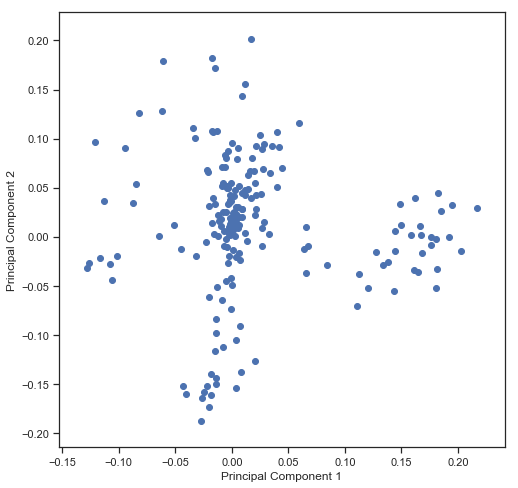

In [107]:
# Let's have a look on Features after applying PCA
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [108]:
# Let's check for variance ratio
pca.explained_variance_ratio_

array([7.54352837e-02, 5.22263371e-02, 3.80054398e-02, 2.91606363e-02,
       2.59532987e-02, 2.22214036e-02, 2.06273760e-02, 1.93655524e-02,
       1.62638551e-02, 1.53717639e-02, 1.53082822e-02, 1.47440856e-02,
       1.40255654e-02, 1.34706342e-02, 1.33758923e-02, 1.31152711e-02,
       1.30682829e-02, 1.21921530e-02, 1.17847246e-02, 1.16954899e-02,
       1.13113057e-02, 1.08214657e-02, 1.06645754e-02, 1.03393507e-02,
       1.03004847e-02, 9.85796972e-03, 9.64915872e-03, 9.44187920e-03,
       9.29973679e-03, 9.05929060e-03, 8.94540618e-03, 8.76266481e-03,
       8.62955093e-03, 8.33525616e-03, 8.31342331e-03, 8.20076698e-03,
       8.16683999e-03, 7.99670956e-03, 7.86925782e-03, 7.68232051e-03,
       7.61055747e-03, 7.48886877e-03, 7.30364189e-03, 7.14279545e-03,
       7.01587439e-03, 6.93147685e-03, 6.81666294e-03, 6.74981807e-03,
       6.47122903e-03, 6.37785289e-03, 6.33580030e-03, 6.03108503e-03,
       5.89047840e-03, 5.84273770e-03, 5.77148864e-03, 5.65716034e-03,
      

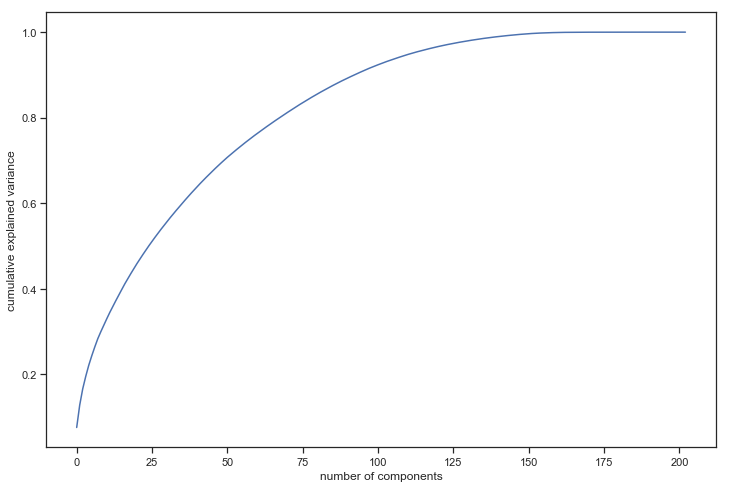

In [109]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [110]:
print("pca.explained_variance_ratio_: ",pca.explained_variance_ratio_.round(3)*100)

pca.explained_variance_ratio_:  [7.5 5.2 3.8 2.9 2.6 2.2 2.1 1.9 1.6 1.5 1.5 1.5 1.4 1.3 1.3 1.3 1.3 1.2
 1.2 1.2 1.1 1.1 1.1 1.  1.  1.  1.  0.9 0.9 0.9 0.9 0.9 0.9 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0. ]


In [111]:
print (pca.explained_variance_ratio_.cumsum())

[0.07543528 0.12766162 0.16566706 0.1948277  0.220781   0.2430024
 0.26362978 0.28299533 0.29925918 0.31463095 0.32993923 0.34468331
 0.35870888 0.37217951 0.38555541 0.39867068 0.41173896 0.42393111
 0.43571584 0.44741133 0.45872263 0.4695441  0.48020867 0.49054803
 0.50084851 0.51070648 0.52035564 0.52979752 0.53909725 0.54815655
 0.55710195 0.56586462 0.57449417 0.58282942 0.59114285 0.59934361
 0.60751045 0.61550716 0.62337642 0.63105874 0.6386693  0.64615817
 0.65346181 0.6606046  0.66762048 0.67455196 0.68136862 0.68811844
 0.69458967 0.70096752 0.70730332 0.7133344  0.71922488 0.72506762
 0.73083911 0.73649627 0.74208537 0.74755826 0.75297948 0.75830994
 0.76349969 0.76864966 0.7737713  0.77878726 0.78376862 0.78868512
 0.79356247 0.79834216 0.80310265 0.80780714 0.81248582 0.81707732
 0.8216576  0.82617121 0.83067599 0.83500741 0.83932098 0.84357424
 0.84777627 0.85190632 0.85597278 0.85993761 0.86384439 0.86770249
 0.87150369 0.8752869  0.87896918 0.88256351 0.8860823  0.88952

In [112]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=54)

In [113]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(23962, 54)

In [114]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

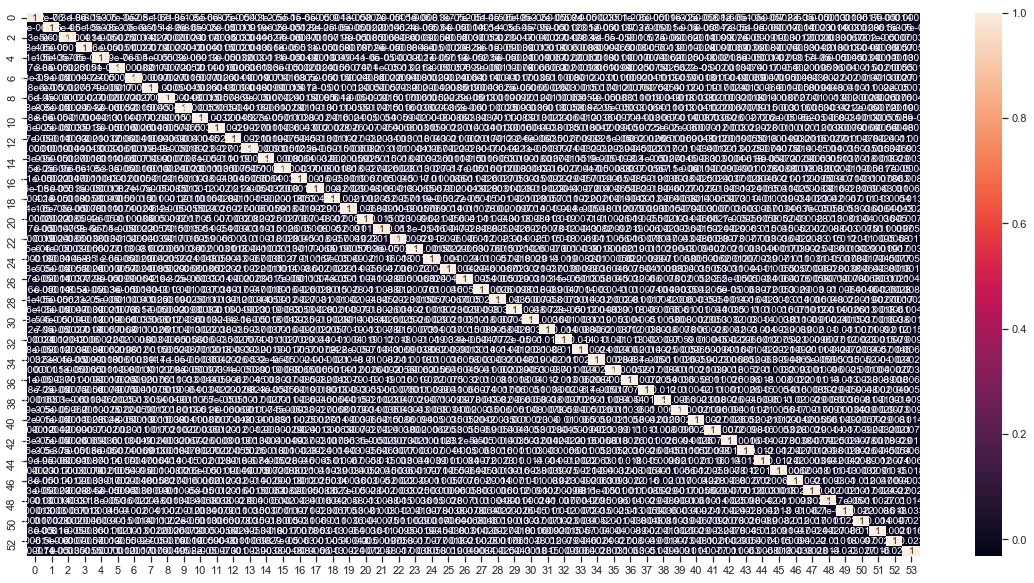

In [115]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [116]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.02836212940215661 , min corr:  -0.03261009862684407


In [117]:
#Applying selected components to the test data
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(5991, 54)

### Logistic Regression

Logistic Regression is a classification algorithm. It is used to predict a binary outcome or Multi class outcome, given a set of independent variables. Logistic regression is a special case of linear regression when the outcome variable is categorical, where we are using log of odds as dependent variable. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function.

Let's first fit a model with default hyperparameters.

In [118]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

In [119]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.89'

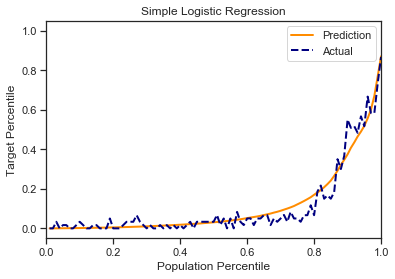

In [120]:
plotLiftChart(y_test.values,pred_probs_test,"Simple Logistic Regression")

- Here we used 54 components, which could nearly explain 85% variance in dataset
- We were able to achieve 89% Area under the curve on the test set

Let's build couple of more models with different number of components. Let's see if the results changes

In [121]:
pca_last1 = PCA(n_components=48)
df_train_pca1 = pca_last1.fit_transform(X_train)
df_test_pca1 = pca_last1.transform(X_test)
df_test_pca1.shape

(5991, 48)

In [ ]:
#training the regression model
learner_pca1 = LogisticRegression()
model_pca1 = learner_pca1.fit(df_train_pca1,y_train)
#Making prediction on the test data
pred_probs_test1 = model_pca1.predict_proba(df_test_pca1)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test1))

'0.89'

In [ ]:
pca_last2 = PCA(n_components=15)
df_train_pca2 = pca_last2.fit_transform(X_train)
df_test_pca2 = pca_last2.transform(X_test)
df_test_pca2.shape

(5991, 15)

In [ ]:
#training the regression model
learner_pca2 = LogisticRegression()
model_pca2 = learner_pca2.fit(df_train_pca2,y_train)
#Making prediction on the test data
pred_probs_test2 = model_pca2.predict_proba(df_test_pca2)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test2))

'0.88'

### Choice of Evaluation Metric

Choosing a metric is one of the key criteria for our analysis, as the dataset is imbalanced one

Source: Wikipedia

Accuracy = correct predictions / total predictions = (TP + TN)/ (all) For a data set which is balanced, this might make a good measure. For an imbalanced dataset like the current one, where the negative class is heavier, this measure may show a high accuracy but fail to serve the purpose of the modeling exercise. We need to be able to predict non-churn i.e.; positive outcomes correctly to help business. So Accuracy may not be the best measure here.

Recall(sensitivity) = ability to identify Positives as true = TP/(TP + FN) Considering that we wish to clearly identify customers who might churn vs non-churn, recall as a metric with its ability to identify true positives might be more apt. But this does not capture models ability to mis-classify negative class as positive i.e.; False positive rate. So, if we choose a model purely based on recall, we might be blind sighted by a huge number of false positive.

Precision = TP/ (TP + FP) = Positive predictive value: It is important to not only understand the rate of identifying positives as true but also identify False positives. If business is to make a decision on marketing spend to retain customers to all positive output of the model, it becomes important that the false positive rate should not be too high. So Precision as a metric - which provides the rate of true positive /total predicted positives is an apt metric to look at here.

F Score = 2 Precision Recall/ (Precision * Recall): Fscore is the harmonic mean of Precision and Recall and provides the ability to balance the need between having a better true positive rate and not too high a false positive rate.

Area under the Curve:

AUC or in the classification world – AUC ROC – Area under the curve for Receiver Operating Characteristic curve is generally used to compare two different models. It used two metrics from the confusion matrix the true positive rate and false positive rate.

True positive rate (TPR), recall as described above is proportion of positive data points correctly identified as positive by the model False positive rate (FPR), which is defined as FP/(FP+TN) is all the negative data points that are mistakenly identified as positive as a proportion of all negative data points.

The TPR and FPR metrics are calculated for several threshold values and a curve is plotted with these. The resulting curve is called ROC. AUC is the computation of the area under ROC curve. For a model selection, we always look for maximizing the AUC for the classifier. As this value is comparable across models.

### Logistic Regression - with penalty

In [ ]:
# Importing library
from sklearn.feature_selection import RFE

In [ ]:
#Initialising logistic regression with custom configuration
logmodel_CW_dict = LogisticRegression(class_weight='balanced',penalty='l2',random_state=9999,solver='newton-cg',C=10000000,n_jobs=-1)

In [ ]:
# Fit model on PCA data sample
logmodel_CW_dict.fit(df_train_pca,y_train)

LogisticRegression(C=10000000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=9999,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      5339
           1       0.34      0.84      0.49       652

   micro avg       0.81      0.81      0.81      5991
   macro avg       0.66      0.82      0.68      5991
weighted avg       0.91      0.81      0.84      5991

Accuracy for the test dataset 80.7%
ROC for the test dataset 82.2%


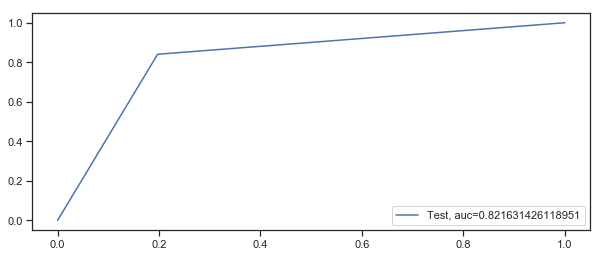

In [ ]:
# Making predictions 
predictions = logmodel_CW_dict.predict(df_test_pca)
prediction_probs = logmodel_CW_dict.predict_proba(df_test_pca)[:,1]
print(classification_report(y_test, predictions))
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

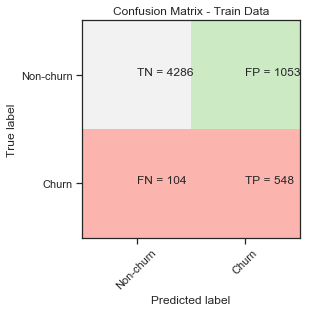

In [ ]:
# Creating confusion matrix 
cm = confusion_matrix(y_test, predictions)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

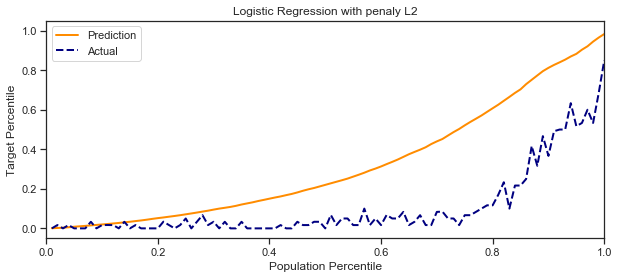

In [ ]:
# Plotting lift metrics using plotLiftChart
plotLiftChart(y_test.values,prediction_probs,"Logistic Regression with penaly L2")

### Create Stratefied Kfold Samples
The regular K-Fold cross validation may not be applicable for an imbalanced dataset. As the folds created may not retain class proportions, even if they did, most classifiers need some manipulation of the dataset to balance it (oversampling of positive class or under sampling of negative class).
To Cross validate an imbalanced dataset, we might have to apply stratified cross validation. Stratification seeks to ensure that each fold is representative of all classes of the data.

- Random Sampling: The given dataset is highly imbalanced. Churn classes is only 10% of the entire dataset. With such a dataset random sampling might not be able to pick up enough data of both the classes
- Stratified Sampling: Stratified sampling will be able to sample enough data of both the classes. But, considering that the churn class is only 10% of the entire dataset, stratified sampling might significantly reduce the number of cases, so it should ideally be coupled with a resampling technique to ensure balance in data.

In [ ]:
#importing library
from sklearn.model_selection  import StratifiedKFold
stratefied_Kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=9999)

In [ ]:
# Creating logisting regression with custom configuration
from sklearn.linear_model import LogisticRegressionCV

searchCV = LogisticRegressionCV(
        Cs= list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=stratefied_Kfold
        ,random_state=777
        ,max_iter=100
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=1
        ,verbose = 2
        ,n_jobs = -1
    
    )

In [ ]:
# Fitting the model on PCA data sample
searchCV.fit(df_train_pca,y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.0s finished


LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0],
           class_weight=None,
           cv=StratifiedKFold(n_splits=4, random_state=9999, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
           random_state=777, refit=True, scoring='roc_auc',
           solver='newton-cg', tol=1, verbose=2)

In [ ]:
# Printing the value of optimum lambda
print("final selected 1/lambda is ", searchCV.C_)
print("final selected lambda is ", 1/searchCV.C_)

final selected 1/lambda is  [10.]
final selected lambda is  [0.1]


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5339
           1       0.66      0.37      0.47       652

   micro avg       0.91      0.91      0.91      5991
   macro avg       0.79      0.67      0.71      5991
weighted avg       0.90      0.91      0.90      5991

Accuracy for the test dataset 91.0%
ROC for the test dataset 88.8%


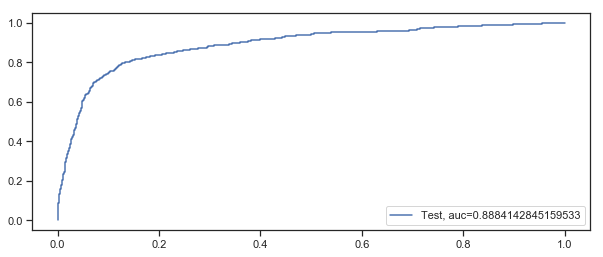

In [ ]:
#train data
preds_L2Search = searchCV.predict(df_test_pca)
preds_L2Search_probs = searchCV.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_L2Search))
accuracy = metrics.accuracy_score(y_test, preds_L2Search)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_L2Search_probs)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

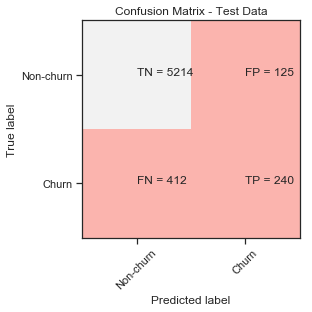

In [ ]:
# Let's plot confusion matrix
cm = confusion_matrix(y_test, preds_L2Search)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()


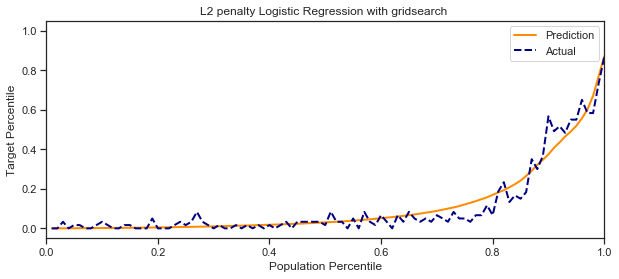

In [ ]:
# Plotting lift metrics 
plotLiftChart(y_test.values,preds_L2Search_probs,"L2 penalty Logistic Regression with gridsearch ")

### Random Forest

Random forest algorithm is based on a concept called bagging - bootstrap aggregating. In random forest, we build a number of decision trees on bootstrap training samples. The samples are chosen, as split candidates from all the X variables (predictors).
So, the random forest at each split is allowed to consider a subset of the predictors. If not, One or Few strong predictors, might always become the most important predictor leading to similar looking trees. Which leads to no reduction in the variance. This process can be thought of as de-correlating the trees or feature bagging. Because of this, the Random forest can also be used to rank the importance of variables.
Similarly bootstrapping of sample rows is also done.

Let's first fit a random forest model with default hyperparameters.

In [ ]:
# Importing library and creating random foret object with custom configuration
from sklearn.ensemble import RandomForestClassifier
RFC_balanced = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,
                                      min_samples_split=500, min_samples_leaf=1, 
                                      min_weight_fraction_leaf=0.0, max_features='auto', 
                                      max_leaf_nodes=None, min_impurity_split=1e-07,
                                      bootstrap=True, oob_score=False, n_jobs=-1, 
                                      random_state=9999, verbose=0, warm_start=False, 
                                      class_weight="balanced_subsample")

In [ ]:
# fit the data on PCA sample
TrainedRFC= RFC_balanced.fit(df_train_pca,y_train)

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      5339
           1       0.38      0.81      0.52       652

   micro avg       0.83      0.83      0.83      5991
   macro avg       0.68      0.82      0.71      5991
weighted avg       0.91      0.83      0.86      5991

Accuracy for the test dataset 83.5%
ROC for the test dataset 88.5%


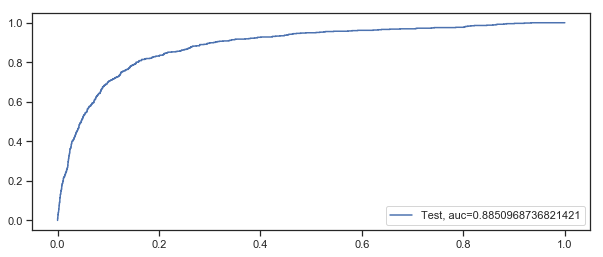

In [ ]:
# Making predictions
preds_RFC=TrainedRFC.predict(df_test_pca)
preds_probs_RFC=TrainedRFC.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_RFC))
accuracy = metrics.accuracy_score(y_test, preds_RFC)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_probs_RFC)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


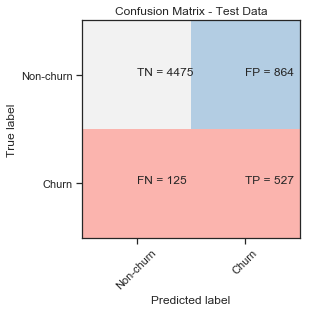

In [ ]:
# Creating and plotting confusion matrix 
cm = confusion_matrix(y_test, preds_RFC)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

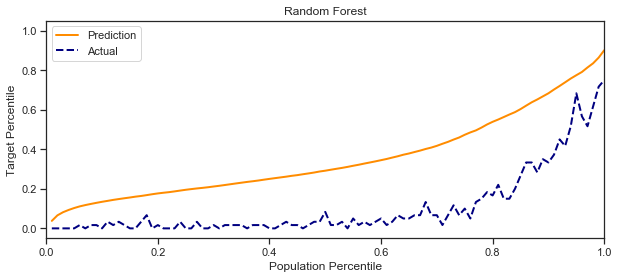

In [ ]:
# plotting lift metrics
plotLiftChart(y_test.values,preds_probs_RFC,"Random Forest")

In [ ]:
# Let's have a look on predictor variable sorted based on their contribution
importances = TrainedRFC.feature_importances_
col_names =  X.columns

sorted_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns=list(['value','colName']))
sorted_feature_importance


value             colName
0    0.36         onnet_mou_8
1    0.07        offnet_mou_8
2    0.05       roam_ic_mou_8
3    0.04       roam_og_mou_8
4    0.04     count_rech_3g_6
5    0.03    std_ic_t2m_mou_8
6    0.03              arpu_8
7    0.02     max_rech_data_6
8    0.02  av_rech_amt_data_7
9    0.02     max_rech_data_7
10   0.02        spl_og_mou_8
11   0.02    loc_og_t2t_mou_8
12   0.02    night_pck_user_8
13   0.02        isd_ic_mou_8
14   0.02           fb_user_8
15   0.02        loc_og_mou_8
16   0.01           arpu_3g_8
17   0.01      max_rech_amt_6
18   0.01     count_rech_3g_8
19   0.01         vol_3g_mb_8
20   0.01        isd_og_mou_8
21   0.01   total_rech_data_8
22   0.01   total_rech_data_6
23   0.01        std_og_mou_8
24   0.01  av_rech_amt_data_6
25   0.01   total_rech_data_7
26   0.01         vol_2g_mb_8
27   0.01        loc_ic_mou_8
28   0.01     max_rech_data_8
29   0.01    loc_og_t2f_mou_8
30   0.01      max_rech_amt_8
31   0.01      max_rech_amt_7
32   0.01         og_others_8
33   0.00  last_day_rch_amt_8
34   0.00    loc_og_t2m_mou_8
35   0.00    loc_ic_t2f_mou_8
36   0.00    std_ic_t2f_mou_8
37   0.00    loc_ic_t2m_mou_8
38   0.00         ic_others_8
39   0.00    std_ic_t2t_mou_8
40   0.00  last_day_rch_amt_7
41   0.00    total_rech_num_8
42   0.00        std_ic_mou_8
43   0.00  av_rech_amt_data_8
44   0.00          aug_vbc_3g
45   0.00    std_og_t2f_mou_8
46   0.00                 aon
47   0.00        spl_ic_mou_8
48   0.00     count_rech_3g_7
49   0.00    loc_ic_t2t_mou_8
50   0.00        monthly_3g_8
51   0.00        monthly_2g_8
52   0.00    loc_og_t2c_mou_8
53   0.00  last_day_rch_amt_6

<Figure size 720x288 with 0 Axes>

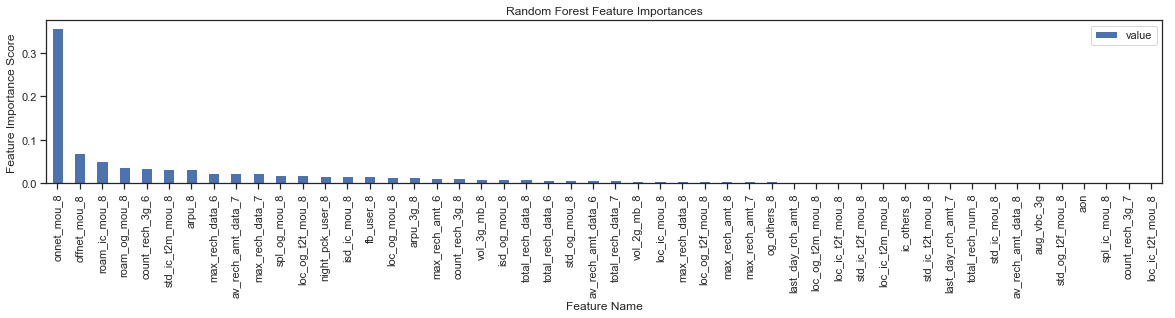

In [ ]:
# Plotting the important predictor varibles 
plt.clf()
from pylab import rcParams
rcParams['figure.figsize'] = 20, 3
sorted_feature_importance[0:50].plot(x='colName', y='value' , kind='bar', title='Random Forest Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature Name')
plt.show()

### Gradient boosting

Boosting is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set.

Gradient boosting uses the concept of boosting. It also fits separate decision trees to the training data set but the trees are grown sequentially essentially to fix the mistakes of the previous tree. This is why, boosting is called the ensemble of weak prediction models. Suppose the gradient boosting model starts with a weak model Fm. In the next iteration it tries to add to the previous weak model, in such a way, that the prediction becomes stronger, i.e;

                      Fm+1(x) =  Fm (x) + h(x)= y
Here h is essentially a residual from the previous model, so gradient boosting is a generalization of the gradient decent algorithm that reduces the residuals.

In [ ]:
# Importing Library
from sklearn import ensemble

# Fit classifier with out-of-bag estimates
params = {'n_estimators': 200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 10, 'random_state': 9999}
GBC = ensemble.GradientBoostingClassifier(**params)

In [ ]:
# Fit classifier on the PCA data
GBC.fit(df_train_pca,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=9999,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5339
           1       0.69      0.36      0.47       652

   micro avg       0.91      0.91      0.91      5991
   macro avg       0.81      0.67      0.71      5991
weighted avg       0.90      0.91      0.90      5991

Accuracy for the test dataset 91.3%
ROC for the test dataset 89.1%


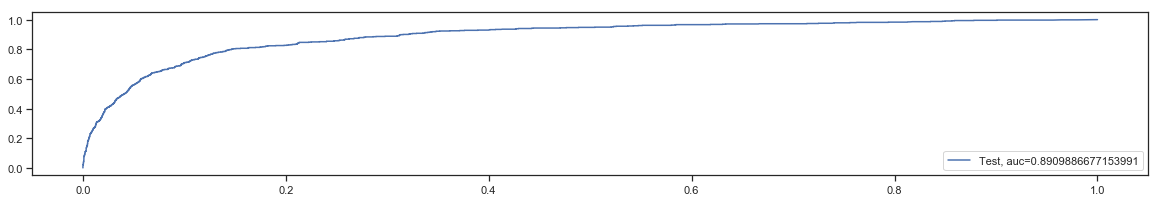

In [ ]:
# Making predictions and calculating accuracy and roc curve
preds_GBC = GBC.predict(df_test_pca)
preds_probs_GBC = GBC.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_GBC))
accuracy = metrics.accuracy_score(y_test, preds_GBC)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy))

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_probs_GBC)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

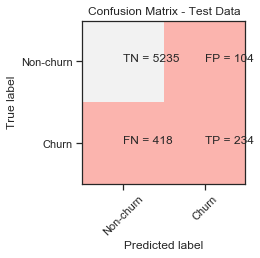

In [ ]:
# Creating and plotting confusion matrix
cm = confusion_matrix(y_test, preds_GBC)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

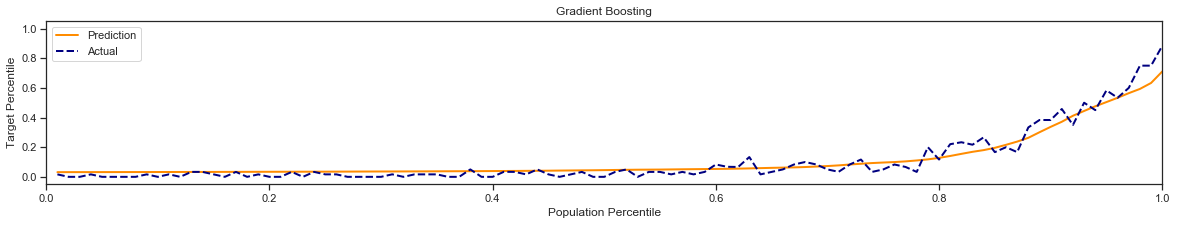

In [ ]:
# Plotting lift metrics
plotLiftChart(y_test.values,preds_probs_GBC,"Gradient Boosting")

### Support Vector Machine
Support Vector Machine (SVM) is an algorithm used for classification problems similar to Logistic Regression (LR). LR and SVM with linear Kernel generally perform comparably in practice.
The objective of the support vector machine algorithm is to find the hyperplane that has the maximum margin in an N-dimensional space that distinctly classifies the data points. Data points falling on either side of the hyperplane can be attributed to different classes.
The dimension of the hyperplane depends upon the number of features. If the number of input features is 2, then the hyperplane is just a line. If the number of input features is 3, then the hyperplane becomes a two-dimensional plane. Support vectors are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane. Using these support vectors, we maximize the margin of the classifier. Deleting the support vectors will change the position of the hyperplane.

Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5339
           1       0.70      0.45      0.55       652

   micro avg       0.92      0.92      0.92      5991
   macro avg       0.82      0.71      0.75      5991
weighted avg       0.91      0.92      0.91      5991


Accuracy for the test dataset 91.9%

ROC for the test dataset 71.2%


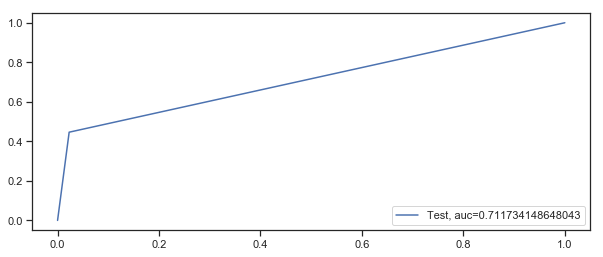

In [ ]:
# importing library
from sklearn import svm 

# rbf kernel with other hyperparameters kept to default 
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(df_train_pca, y_train)
# Making predictions and calculating accuracy and roc curve
predictions = svm_rbf.predict(df_test_pca)
print("Classification report: ")
print(classification_report(y_test,predictions))
accuracy = metrics.accuracy_score(y_test, predictions)
print("\nAccuracy for the test dataset",'{:.1%}'.format(accuracy) )
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
print("\nROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

### Model Building
__On original features (instead of principal components)__


### Logistic Regression with penalty

In [ ]:
# Importing library 
from sklearn.linear_model import LogisticRegressionCV
# Creating logistic regression using custom configuration
searchCV = LogisticRegressionCV(
        Cs= list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=stratefied_Kfold
        ,random_state=777
        ,max_iter=100
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=1
        ,verbose = 2
        ,n_jobs = -1
    
    )

In [ ]:
# Fit model on actual data( without PCA)
searchCV.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   11.0s finished


LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0],
           class_weight=None,
           cv=StratifiedKFold(n_splits=4, random_state=9999, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
           random_state=777, refit=True, scoring='roc_auc',
           solver='newton-cg', tol=1, verbose=2)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5339
           1       0.68      0.44      0.53       652

   micro avg       0.92      0.92      0.92      5991
   macro avg       0.81      0.71      0.74      5991
weighted avg       0.91      0.92      0.91      5991

Accuracy for the test dataset 91.6%
ROC for the test dataset 89.8%


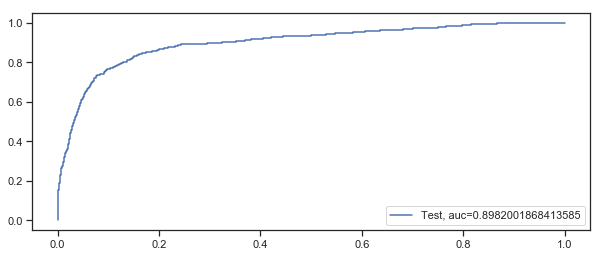

In [ ]:
#train data
preds_L2Search = searchCV.predict(X_test)
preds_L2Search_probs = searchCV.predict_proba(X_test)[:,1]

# Making predictions and calculating accuracy and roc curve

print(classification_report(y_test, preds_L2Search))
accuracy = metrics.accuracy_score(y_test, preds_L2Search)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_L2Search_probs)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


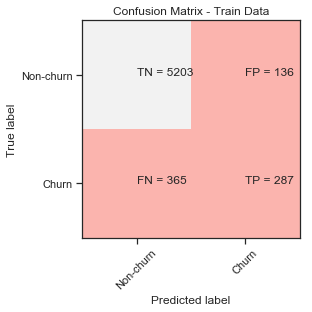

In [ ]:
# Creating and plotting confusion matrix
cm = confusion_matrix(y_test, preds_L2Search)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

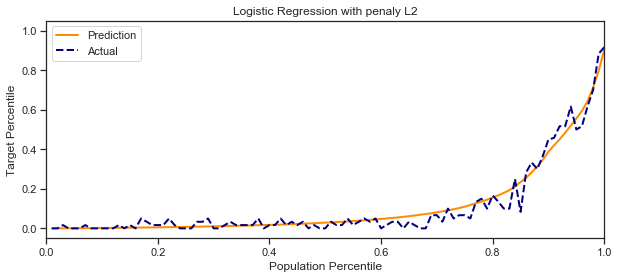

In [ ]:
# plotting lift metrics
plotLiftChart(y_test.values,preds_L2Search_probs,"Logistic Regression with penaly L2")


### Random Forest

In [ ]:
# fit model on the actual data( without PCA)
TrainedRFC= RFC_balanced.fit(X_train,y_train)

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      5339
           1       0.42      0.82      0.55       652

   micro avg       0.86      0.86      0.86      5991
   macro avg       0.70      0.84      0.73      5991
weighted avg       0.91      0.86      0.87      5991

Accuracy for the test dataset 85.6%
ROC for the test dataset 91.9%


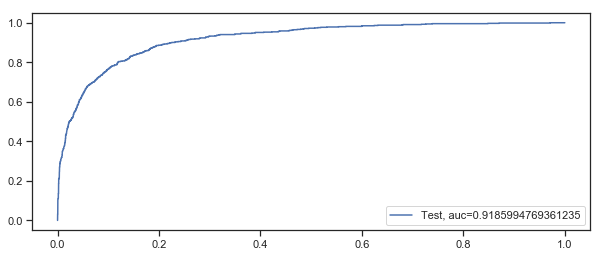

In [ ]:
# Making predictions 
preds_RFC=TrainedRFC.predict(X_test)
preds_probs_RFC=TrainedRFC.predict_proba(X_test)[:,1]

# Calculating accuracy and plotting roc curve
print(classification_report(y_test, preds_RFC))
accuracy = metrics.accuracy_score(y_test, preds_RFC)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_probs_RFC)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

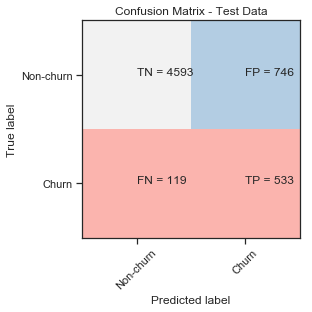

In [ ]:
# Plotting confusion matrix
cm = confusion_matrix(y_test, preds_RFC)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

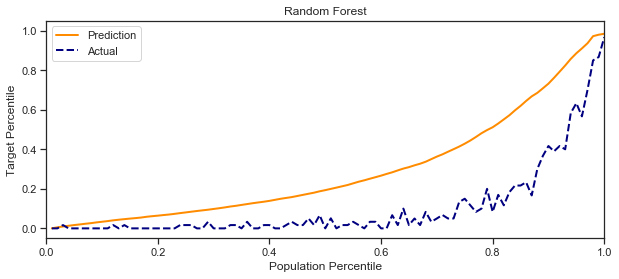

In [ ]:
# plotting lift metrics
plotLiftChart(y_test.values,preds_probs_RFC,"Random Forest")

In [ ]:
# List of predictor variables in actual data set sorted based on thier contribution in the model
col_names =  X.columns

sorted_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns=list(['value','colName']))
sorted_feature_importance

value             colName
0    0.36         onnet_mou_8
1    0.07        offnet_mou_8
2    0.05       roam_ic_mou_8
3    0.04       roam_og_mou_8
4    0.04     count_rech_3g_6
5    0.03    std_ic_t2m_mou_8
6    0.03              arpu_8
7    0.02     max_rech_data_6
8    0.02  av_rech_amt_data_7
9    0.02     max_rech_data_7
10   0.02        spl_og_mou_8
11   0.02    loc_og_t2t_mou_8
12   0.02    night_pck_user_8
13   0.02        isd_ic_mou_8
14   0.02           fb_user_8
15   0.02        loc_og_mou_8
16   0.01           arpu_3g_8
17   0.01      max_rech_amt_6
18   0.01     count_rech_3g_8
19   0.01         vol_3g_mb_8
20   0.01        isd_og_mou_8
21   0.01   total_rech_data_8
22   0.01   total_rech_data_6
23   0.01        std_og_mou_8
24   0.01  av_rech_amt_data_6
25   0.01   total_rech_data_7
26   0.01         vol_2g_mb_8
27   0.01        loc_ic_mou_8
28   0.01     max_rech_data_8
29   0.01    loc_og_t2f_mou_8
30   0.01      max_rech_amt_8
31   0.01      max_rech_amt_7
32   0.01         og_others_8
33   0.00  last_day_rch_amt_8
34   0.00    loc_og_t2m_mou_8
35   0.00    loc_ic_t2f_mou_8
36   0.00    std_ic_t2f_mou_8
37   0.00    loc_ic_t2m_mou_8
38   0.00         ic_others_8
39   0.00    std_ic_t2t_mou_8
40   0.00  last_day_rch_amt_7
41   0.00    total_rech_num_8
42   0.00        std_ic_mou_8
43   0.00  av_rech_amt_data_8
44   0.00          aug_vbc_3g
45   0.00    std_og_t2f_mou_8
46   0.00                 aon
47   0.00        spl_ic_mou_8
48   0.00     count_rech_3g_7
49   0.00    loc_ic_t2t_mou_8
50   0.00        monthly_3g_8
51   0.00        monthly_2g_8
52   0.00    loc_og_t2c_mou_8
53   0.00  last_day_rch_amt_6

<Figure size 720x288 with 0 Axes>

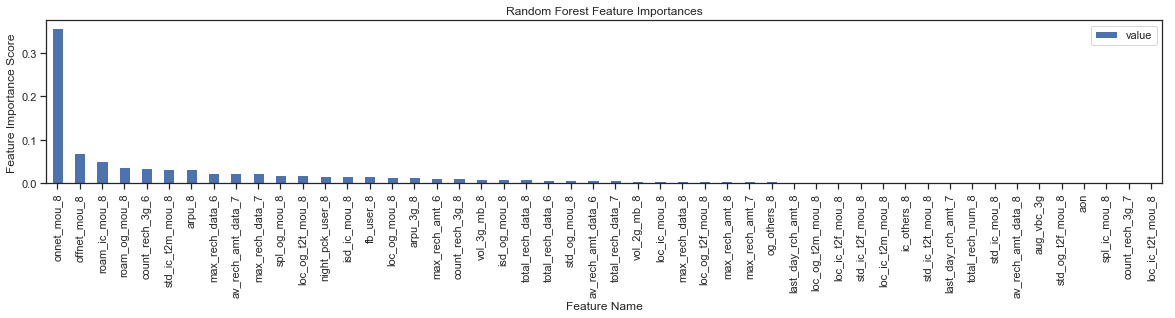

In [ ]:
# plotting the predictor variables
plt.clf()
from pylab import rcParams
rcParams['figure.figsize'] = 20, 3
sorted_feature_importance[0:50].plot(x='colName', y='value' , kind='bar', title='Random Forest Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature Name')

plt.show()

### SVM Linear

In [ ]:
# fitting the model on actual dataset 
svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

In [ ]:
# Making prediction
preds_SVM_li_RS = svm_linear.predict(X_test)

# Calculating accuracy and plotting the ROC curve
print(classification_report(y_test, preds_SVM_li_RS))
accuracy = metrics.accuracy_score(y_test, preds_SVM_li_RS)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_SVM_li_RS)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# Creating confusion matrix
cm = confusion_matrix(y_test, preds_SVM_li_RS)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

### SVM Non-linear (RBF)

In [ ]:
# fitting the model on actual dataset 
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

In [ ]:
# making predictions
preds_SVM_RBF_RS = svm_rbf.predict(X_test)

# Calculating accuracy and plotting ROC curve
print(classification_report(y_test, preds_SVM_RBF_RS))
accuracy = metrics.accuracy_score(y_test, preds_SVM_RBF_RS)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_SVM_RBF_RS)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# creating confusion matrix
cm = confusion_matrix(y_test, preds_SVM_RBF_RS)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

### Important features or indicators

In [ ]:
# Identifying important predictor attributes which help the business understand indicators of churn
importances = RFC_balanced.feature_importances_
col_names =  X.columns

RF_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns={'colName','value'})
RF_feature_importance.head()

In [ ]:
# Identinfying top 20 important features for building the model
imp_features = RF_feature_importance.head(20)

In [ ]:
# Retrieving data from actual dataframe for the selected features
X_imp = data[list(imp_features .colName.unique())]
Y_imp = data['churn_flag']

In [ ]:
# Transforming the model on the selected 20 features
X_imp_std = scaler.fit_transform(X_imp)
# Splitting the data into train and test set
X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(X_imp_std,Y_imp, train_size=0.8,test_size=0.2,random_state=111)

In [ ]:
# fitting the model on train dataset 
RF_imp=RandomForestClassifier(n_estimators=200, criterion= 'entropy', max_depth=15,random_state=111, class_weight='balanced')
RF_imp.fit(X_imp_train, y_imp_train)

In [ ]:
# Making predictions
RF_imp_pred_test = RF_imp.predict(X_imp_test)

# Printing the performance measures
print(classification_report(y_imp_test, RF_imp_pred_test))

In [ ]:
# Defing the method for plotting ROC curve
def Performance(Model,Y,X):
    # Perforamnce of the model
    fpr, tpr, _ = roc_curve(Y, Model.predict_proba(X)[:,1])
    AUC  = auc(fpr, tpr)
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Plotting the ROC curve
Performance(Model=RF_imp,Y=y_imp_test,X=X_imp_test)

In [ ]:
# These are the important predictor attributes which help the business understand indicators of churn
imp_features

We train our random forest algorithm on the top 20 features that we selected above and then we evaluated the performance of our algorithm on the training and testing sets. We can see the AUC & F1-score are pretty similar on training & test datasets which means our model is not overfitting.

In [ ]:
# Plotting the identified important features
plt.clf()
from pylab import rcParams
rcParams['figure.figsize'] = 20, 3
imp_features[0:50].plot(x='colName', y='value' , kind='bar', title='Random Forest Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature Name')

plt.show()

We can observe the top features selected by the Random Forest. So, we can conclude that these are the important indicators of churn

### Recommendations to Business

- After analysis, we can clearly infer that calls that are related to incoming & outgoing within a circle is a key for identifying churn customers.
- Specially the usage during the action pahse when compared to good month i.e. 7th month has reduced.
- The other key factor for churning is that, if the recharge amount shows a dip in the action phase is a sign of churn
- Age on network is also a key feature for identifying the churning, if aon is less than 500 days and their usage is reduced then the customer is definitely going to be churned.
- The usage of mobile data has also reduced when compared with 7th month. So, data usage & amount can also be the other features for understanding the churn behavior.